In [ ]:
%pip install xgboost

In [ ]:
%pip install pykalman

In [ ]:
! pip install pmdarima

In [ ]:
import pandas as pd
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
#kalman
from pykalman import KalmanFilter
from pykalman import UnscentedKalmanFilter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold


# Holt Winters
import numpy as np
import warnings
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#ARIMA
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from google.colab import files
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import pmdarima as pm
from contextlib import redirect_stdout
from io import StringIO
#xgboost
from xgboost import XGBRegressor


In [ ]:
uploaded = files.upload()
file_name = next(iter(uploaded))

Saving Копия Products for forecasting project - raw_data.csv to Копия Products for forecasting project - raw_data (2).csv


In [ ]:
def mean_absolute_percentage_error(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    mask = actual != 0
    return np.mean(np.abs(np.where(actual != 0, (actual - forecast) / actual, 0))) * 100

In [ ]:
data = pd.read_csv(file_name)
data['sale_date'] = pd.to_datetime(data['sale_date'])
data = data[~((data['sale_date'].dt.month == 11) & (data['sale_date'].dt.year == 2023))]

# Filtered data, to remove 2023 November revenues

# <font color='red'> Part 1: Linear regression


In [ ]:
data['hosting'] = data['hosting'].map({'Cloud': 1, 'Data Center': 0})
data['product_id'] = data['product_id'].map({'Product 1': 1, 'Product 2': 2, 'Product 3': 3, 'Product 4': 4, 'Product 5': 5 })
data['sale_date'] = pd.to_datetime(data['sale_date']).apply(lambda x: int(x.timestamp()/3600))


<ipython-input-37-d1b1220400aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hosting'] = data['hosting'].map({'Cloud': 1, 'Data Center': 0})
<ipython-input-37-d1b1220400aa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['product_id'] = data['product_id'].map({'Product 1': 1, 'Product 2': 2, 'Product 3': 3, 'Product 4': 4, 'Product 5': 5 })
<ipython-input-37-d1b1220400aa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

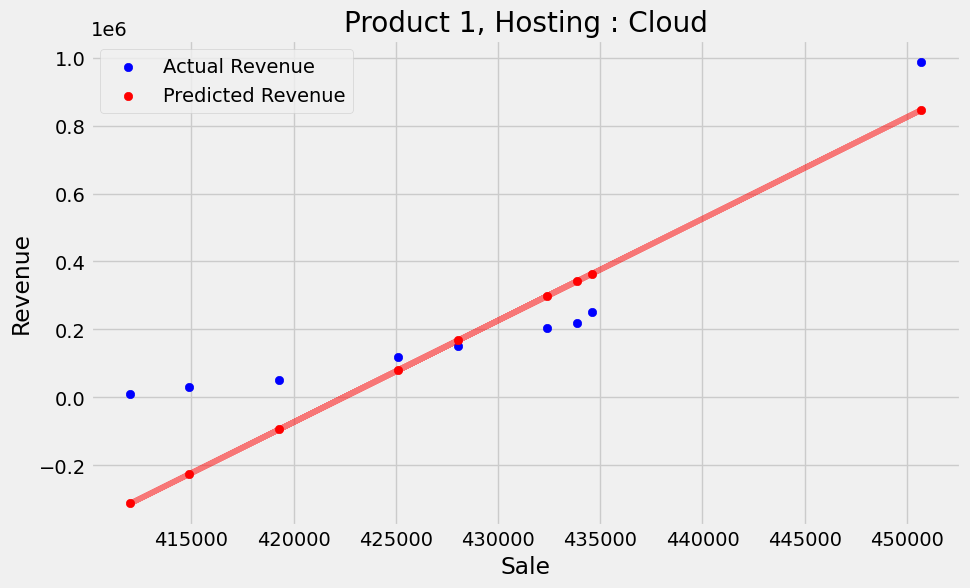

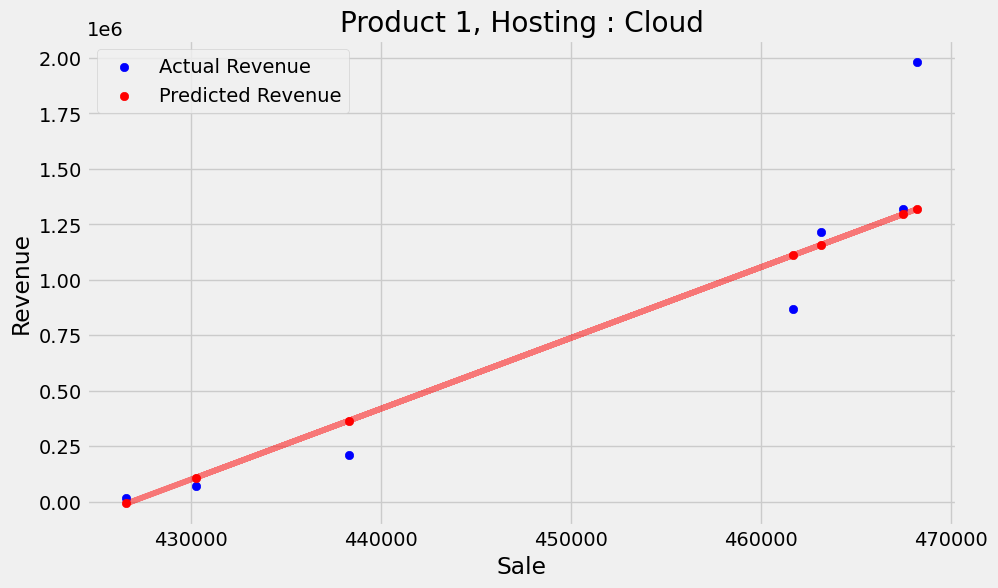

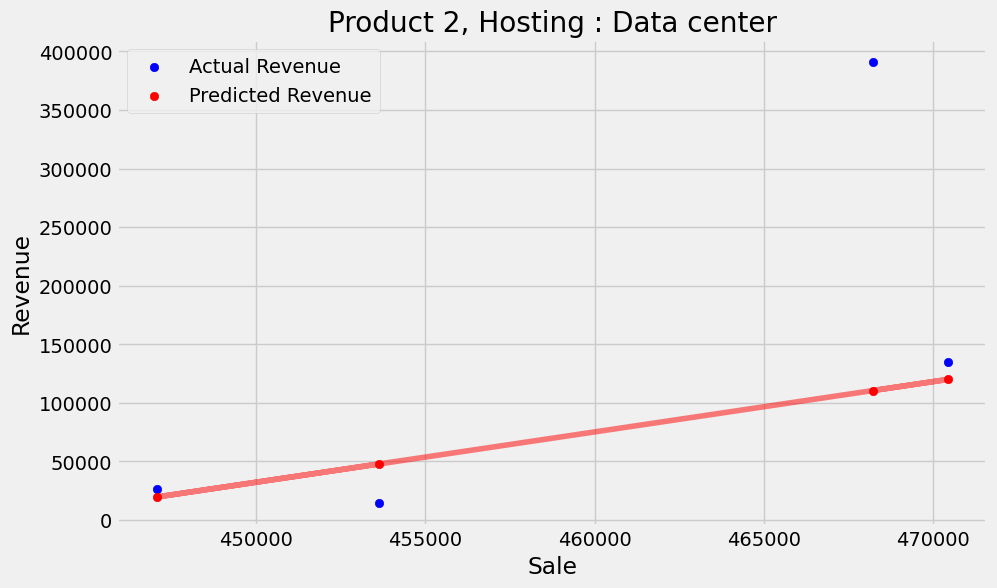

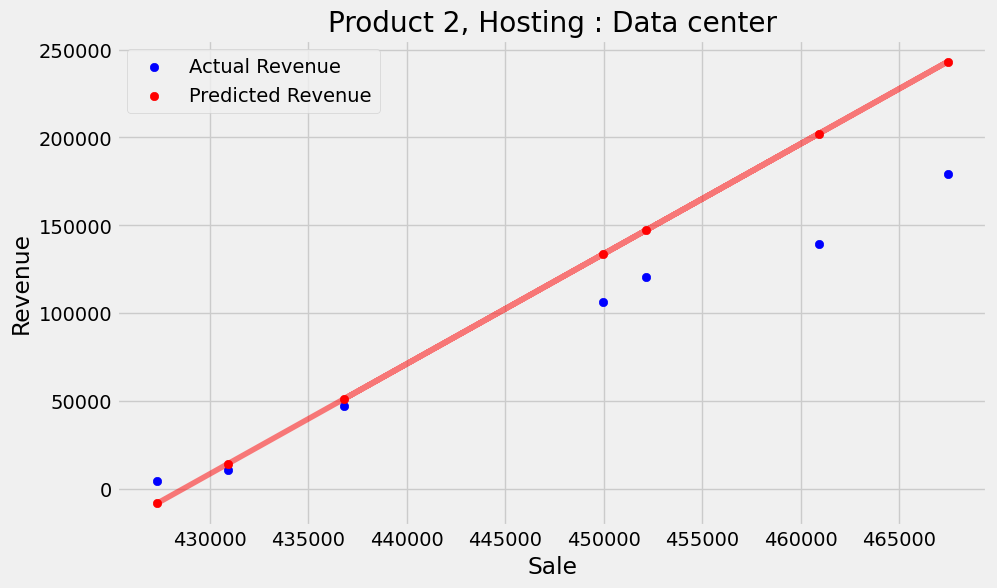

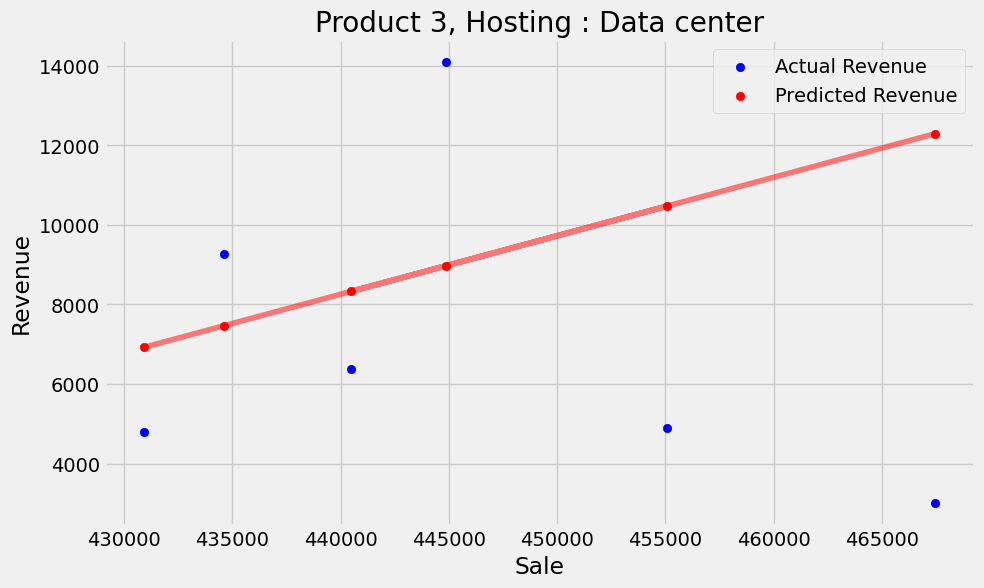

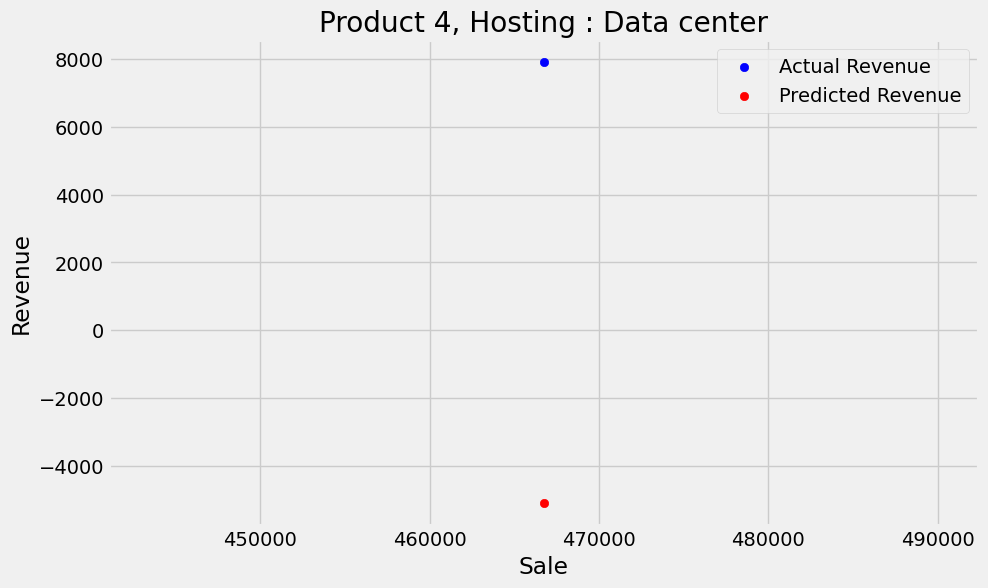

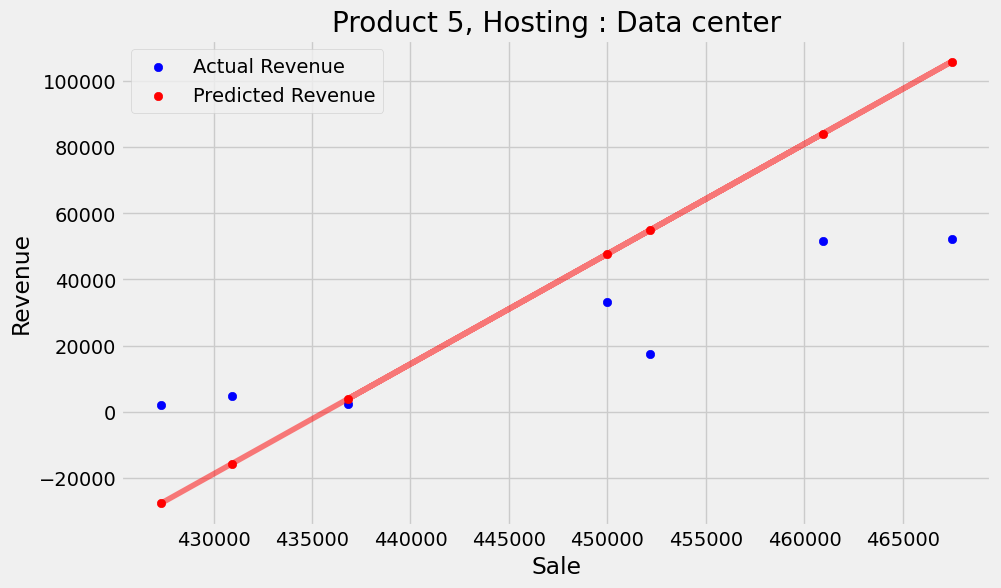

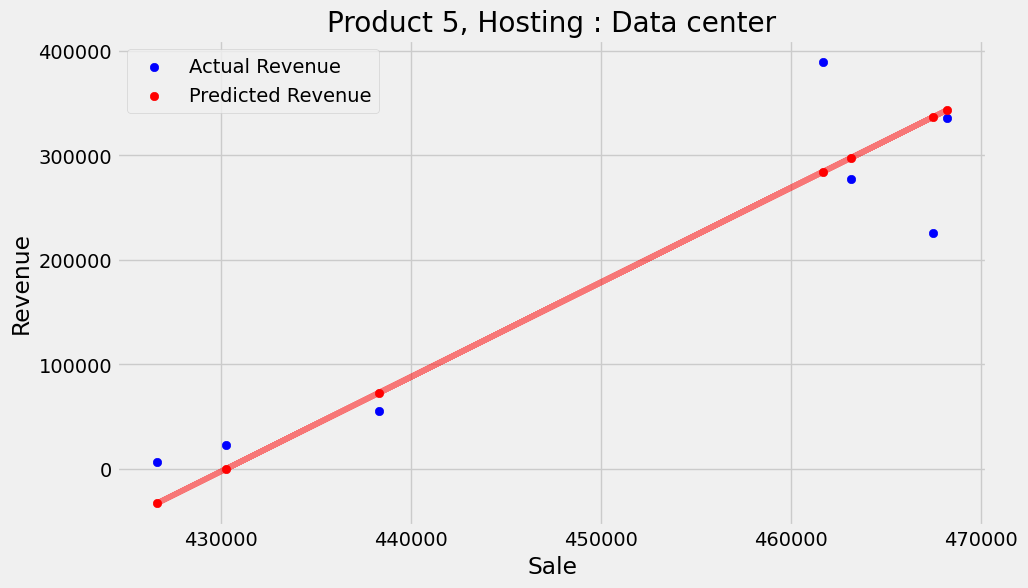

In [ ]:

mapes = []

for i in range(1, 6):
    for j in [1, 0]:
        filtered_data = data[(data['product_id'] == i) & (data['hosting'] == j)]
        if len(filtered_data) == 0 :
          continue
        # print(len(filtered_data))
        filtered_data = filtered_data.drop(['product_id', 'hosting'], axis=1)

        # Sort the data based on the 'sale' values
        filtered_data = filtered_data.sort_values(by='sale_date')

        X = filtered_data[['sale_date']]
        y = filtered_data['revenue']

        # Split the data into a training set and a test set (90% train, 10% test)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

        # Create and train the linear regression model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Make predictions using the test set
        y_pred = model.predict(X_test)

        # Plotting
        plt.figure(figsize=(10, 6))

        # Plot the actual data points
        plt.scatter(X_test, y_test, color='blue', label='Actual Revenue')

        # Plot the predicted data points
        plt.scatter(X_test, y_pred, color='red', label='Predicted Revenue')

        # Optionally, plot a line for the predictions
        plt.plot(X_test, y_pred, color='red', alpha=0.5)

        plt.xlabel('Sale')
        plt.ylabel('Revenue')
        hosting = "Cloud" if i == 1 else "Data center"
        plt.title(f"Product {i}, Hosting : {hosting}")
        plt.legend()
        plt.show()

        def mean_absolute_percentage_error(y_true, y_pred):
          y_true, y_pred = np.array(y_true), np.array(y_pred)
          return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

        # Calculate MAPE
        mape = mean_absolute_percentage_error(y_test, y_pred)
        mapes.append(f" MAPE for Product {i}, Hosting : {hosting} = {mape}")

In [ ]:
mapes

[' MAPE for Product 1, Hosting : Cloud = 534.0301155294662',
 ' MAPE for Product 1, Hosting : Cloud = 49.806152809986415',
 ' MAPE for Product 2, Hosting : Data center = 87.0894983314423',
 ' MAPE for Product 2, Hosting : Data center = inf',
 ' MAPE for Product 3, Hosting : Data center = inf',
 ' MAPE for Product 4, Hosting : Data center = 164.52944052756578',
 ' MAPE for Product 5, Hosting : Data center = 328.1601871956134',
 ' MAPE for Product 5, Hosting : Data center = 121.78151854544001']

# <font color='red'> Part 2: ARIMA


In [ ]:
all_data = pd.read_csv(file_name)
all_data['sale_date'] = pd.to_datetime(all_data['sale_date'])

all_data.sort_values(by='sale_date', inplace=True)
all_data= all_data.reset_index(drop=True)
all_data = all_data[~((all_data['sale_date'].dt.month == 11) & (all_data['sale_date'].dt.year == 2023))]

display(all_data)

product_id      hosting  sale_date     revenue
0    Product 1        Cloud 2017-01-01     9296.25
1    Product 1        Cloud 2017-02-01    14659.78
2    Product 1        Cloud 2017-03-01    16395.75
3    Product 1        Cloud 2017-04-01    22140.00
4    Product 1        Cloud 2017-05-01    29530.54
..         ...          ...        ...         ...
424  Product 2  Data Center 2023-10-01   172713.20
425  Product 4        Cloud 2023-10-01      813.19
426  Product 1        Cloud 2023-10-01  1897427.64
427  Product 1  Data Center 2023-10-01   760811.82
428  Product 5        Cloud 2023-10-01    74434.42

[429 rows x 4 columns]

In [ ]:
all_data2 = all_data.copy()
all_data2.replace('Data Center', 'data', inplace=True)
all_data2.replace('Cloud', 'cloud', inplace=True)
hostings = ['cloud', 'data']

data_dict = {}
log_data_dict={}

param_values = {
    (1, 'cloud'): {'q': 0, 'd': 2, 'r': 5, 'Q': 1, 'D': 2, 'R': 0},
    (1, 'data'): {'q': 1, 'd': 0, 'r': 0, 'Q': 1, 'D': 2, 'R': 2},
    (2, 'cloud'): {'q': 1, 'd': 0, 'r': 2, 'Q': 1, 'D': 2, 'R': 4},
    (2, 'data'): {'q': 2, 'd': 2, 'r': 2, 'Q': 1, 'D': 2, 'R': 1},
    (3, 'data'): {'q': 0, 'd': 2, 'r': 9, 'Q': 0, 'D': 0, 'R': 1},
    (4, 'cloud'): {'q': 1, 'd': 1, 'r': 1, 'Q': 1, 'D': 1, 'R': 1},
    (5, 'cloud'): {'q': 0, 'd': 0, 'r': 0, 'Q': 0, 'D': 1, 'R': 0},
    (5, 'data'): {'q': 0, 'd': 0, 'r': 0, 'Q': 0, 'D': 2, 'R': 2},
}
param_log_values = {
    (1, 'cloud'): {'q': 2, 'd': 2, 'r': 4, 'Q': 3, 'D': 2, 'R': 0},
    (1, 'data'): {'q':1 , 'd':0 , 'r':0 , 'Q':1 , 'D':1 , 'R':1 },
    (2, 'cloud'): {'q':3 , 'd':0, 'r':2 , 'Q':4 , 'D':0 , 'R':2 },
    (2, 'data'): {'q':1 , 'd':2 , 'r':2 , 'Q':0 , 'D':1 , 'R':4 },
    (3, 'data'): {'q':0 , 'd':1 , 'r':8 , 'Q':0 , 'D':0 , 'R':0 },
    (4, 'cloud'): {'q': 1, 'd': 1, 'r': 1, 'Q': 1, 'D': 1, 'R': 1},
    (5, 'cloud'): {'q':0 , 'd':0 , 'r':2 , 'Q':0 , 'D':1 , 'R':2 },
    (5, 'data'): {'q':1 , 'd':0 , 'r':0, 'Q':0 , 'D':2 , 'R':2 },
}
for i in range(1, 6):
    for hosting in hostings:
        if not all_data2[(all_data2['product_id'] == f'Product {i}') & (all_data2['hosting'] == f'{hosting}') & (all_data2['sale_date'] != '2023-11-01')].empty:
          data_dict[f"{i}_{hosting}"] = {
                  'data': all_data2.loc[(all_data2['product_id'] == f'Product {i}') & (all_data2['hosting'] == f'{hosting}') & (all_data2['sale_date'] != '2023-11-01')].reset_index(drop=True).drop(['hosting', 'product_id'], axis=1),
                  'params': param_values.get((i, hosting)),
                  'log_params': param_log_values.get((i, hosting))
                      }

          data_dict[f"{i}_{hosting}"]["data"]['log_revenue'] = np.log(data_dict[f"{i}_{hosting}"]["data"]['revenue'])


          train_var_name = f"train_data_{i}_{hosting}"
          test_var_name = f"test_data_{i}_{hosting}"
          n_periods_var_name = f"n_periods_data_{i}_{hosting}"

          data_dict[f"{i}_{hosting}"]['train'], data_dict[f"{i}_{hosting}"]['test'] = train_test_split(data_dict[f"{i}_{hosting}"]['data'], test_size=0.1, shuffle=False)
          data_dict[f"{i}_{hosting}"]['n_periods'] = len(data_dict[f"{i}_{hosting}"]['test']['revenue'])
        else:
            print(f"No data for combination {i} {hosting}")


No data for combination 3 cloud
No data for combination 4 data


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
def sarima(train, test, n_periods, i, hosting, q, d, r, Q, D, R, log=False, cv=False):
  if cv == False:
    enforce_stationarity = True
  else:
      enforce_stationarity = False
  model_name = f"model_{i}_{hosting}"
  forecast_name = f"forecast_{i}_{hosting}"
  with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=Warning)
        if(log == True):
          globals()[model_name] = sm.tsa.statespace.SARIMAX(train['log_revenue'],
                                                  order=(q, d, r),
                                                  seasonal_order=(Q,D,R,12),
                                          enforce_stationarity=enforce_stationarity,
                                        )
        else:
          globals()[model_name] = sm.tsa.statespace.SARIMAX(train['revenue'],
                                                  order=(q, d, r),
                                                  seasonal_order=(Q,D,R,12),
                                          enforce_stationarity=enforce_stationarity,
                                        )
        results = globals()[model_name].fit()
  globals()[forecast_name] = results.get_forecast(steps=n_periods + 12)
  globals()[forecast_name] = globals()[forecast_name].predicted_mean
  if(log == True):
    globals()[forecast_name] = np.exp(globals()[forecast_name])
  mape = mean_absolute_percentage_error(test['revenue'], globals()[forecast_name][:-12])

  plt.figure(figsize=(10, 6))
  plt.plot(test['sale_date'],test['revenue'], label='Test set', marker='o')
  plt.plot(train['sale_date'],train['revenue'], label="Train set", marker ='o')
  plt.plot(globals()[forecast_name].index, globals()[forecast_name], label='Forecast values', marker='o')

  plt.title(f'Comparison SARIMA product {i} & {hosting}')
  plt.legend()

  return mape, plt

## <font color='red'> **Data Rewiew**

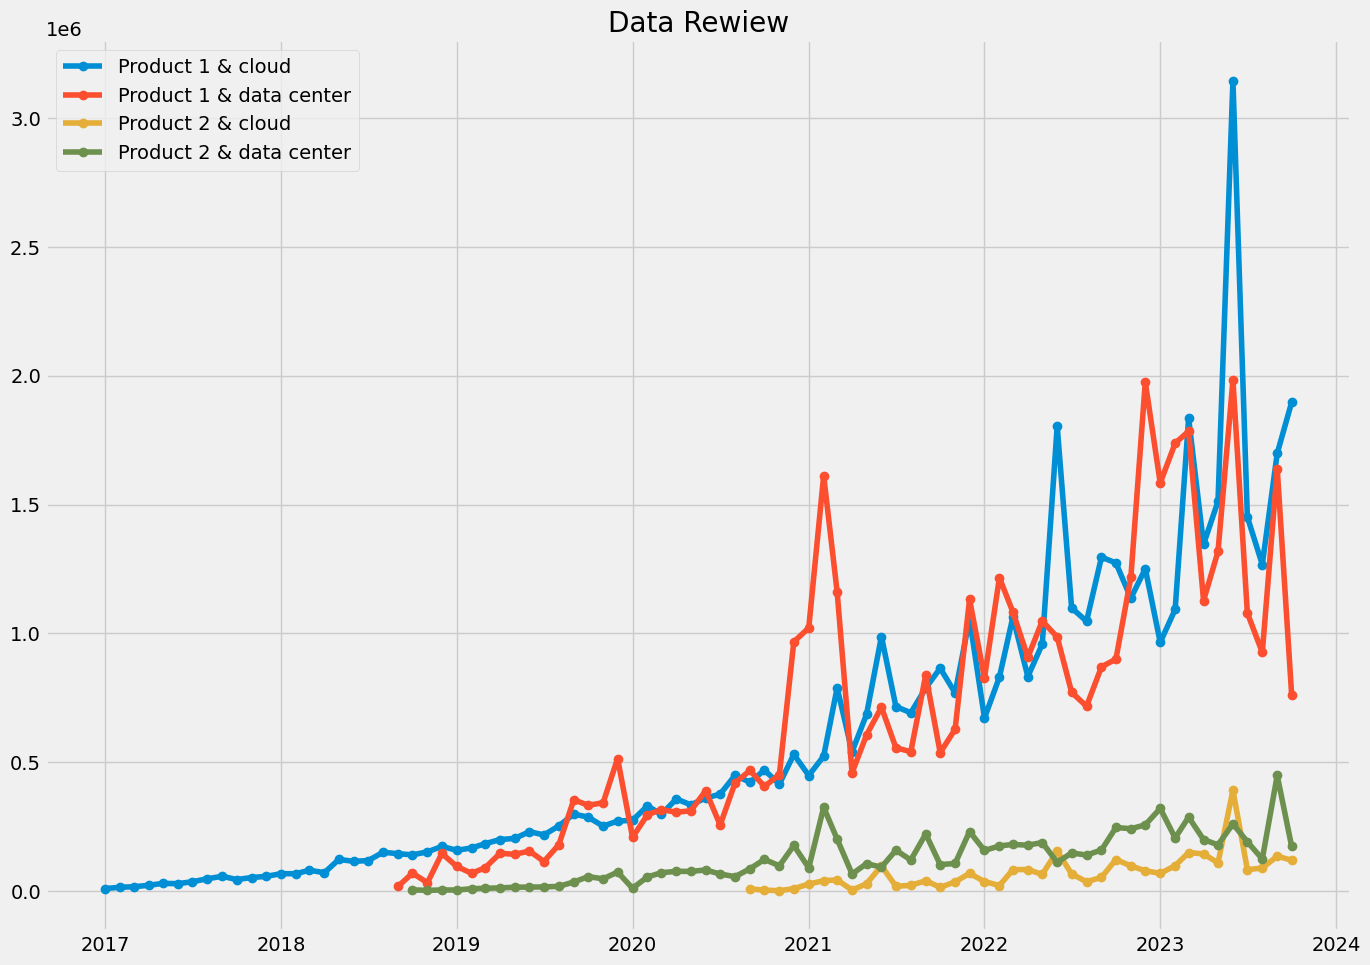

In [ ]:
plt.figure(figsize=(15, 11))
plt.plot(data_dict["1_cloud"]['data']['sale_date'],data_dict["1_cloud"]['data']['revenue'], label=f'Product {1} & {"cloud"}', marker='o')
plt.plot(data_dict["1_data"]['data']['sale_date'],data_dict["1_data"]['data']['revenue'], label=f'Product {1} & {"data center"}', marker='o')
plt.plot(data_dict["2_cloud"]['data']['sale_date'],data_dict["2_cloud"]['data']['revenue'], label=f'Product {2} & {"cloud"}', marker='o')
plt.plot(data_dict["2_data"]['data']['sale_date'],data_dict["2_data"]['data']['revenue'], label=f'Product {2} & {"data center"}', marker='o')



plt.title('Data Rewiew')
plt.legend()
plt.show()

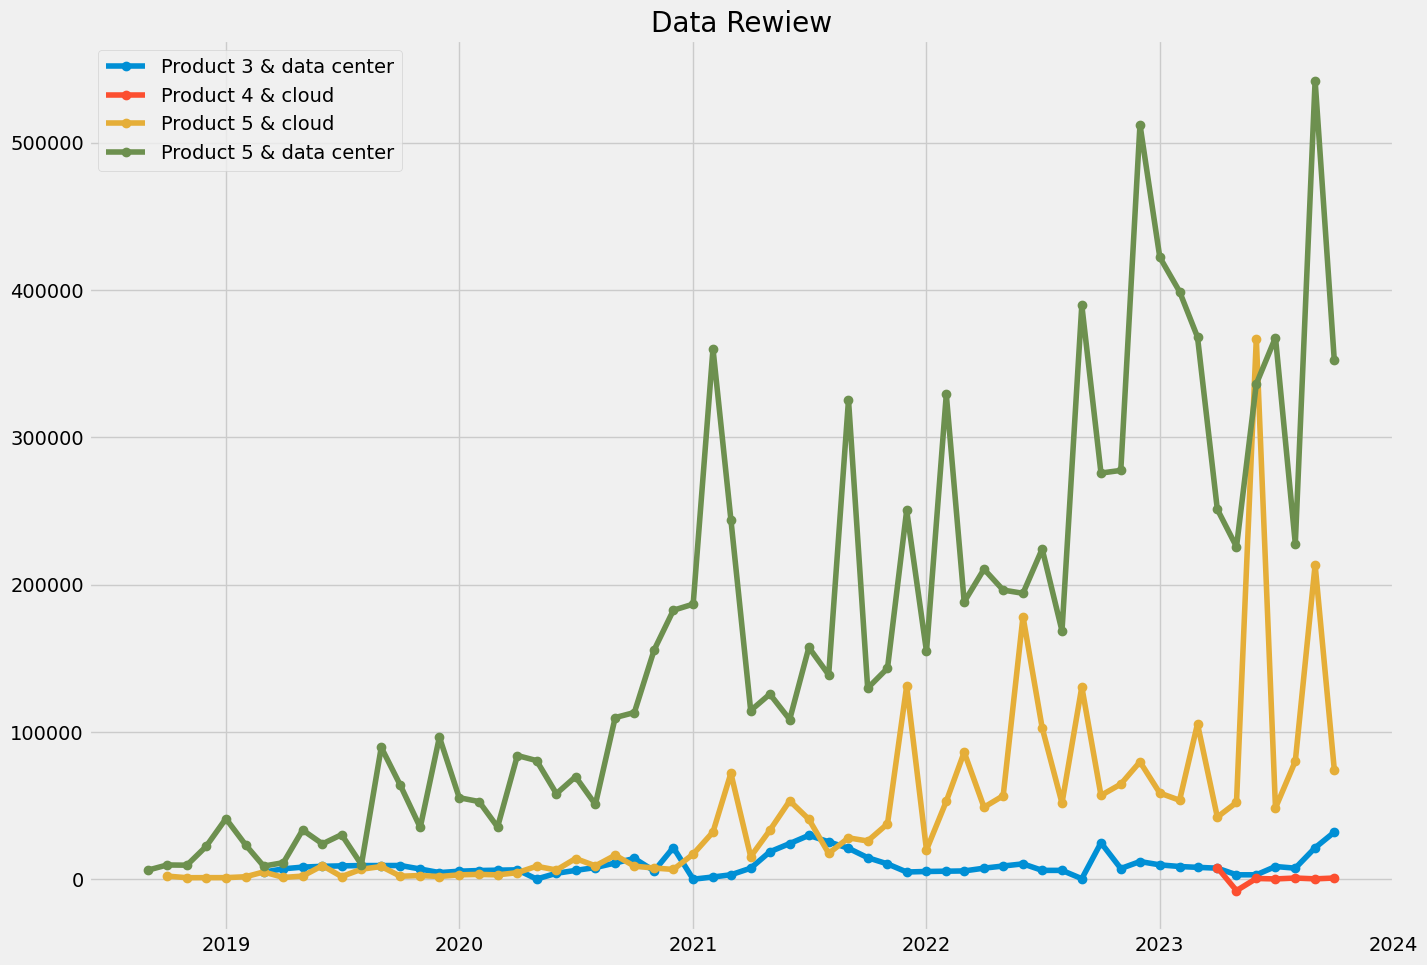

In [ ]:
plt.figure(figsize=(15, 11))
plt.plot(data_dict["3_data"]['data']['sale_date'],data_dict["3_data"]['data']['revenue'], label=f'Product {3} & {"data center"}', marker='o')
plt.plot(data_dict["4_cloud"]['data']['sale_date'],data_dict["4_cloud"]['data']['revenue'], label=f'Product {4} & {"cloud"}', marker='o')
plt.plot(data_dict["5_cloud"]['data']['sale_date'],data_dict["5_cloud"]['data']['revenue'], label=f'Product {5} & {"cloud"}', marker='o')
plt.plot(data_dict["5_data"]['data']['sale_date'],data_dict["5_data"]['data']['revenue'], label=f'Product {5} & {"data center"}', marker='o')



plt.title('Data Rewiew')
plt.legend()
plt.show()

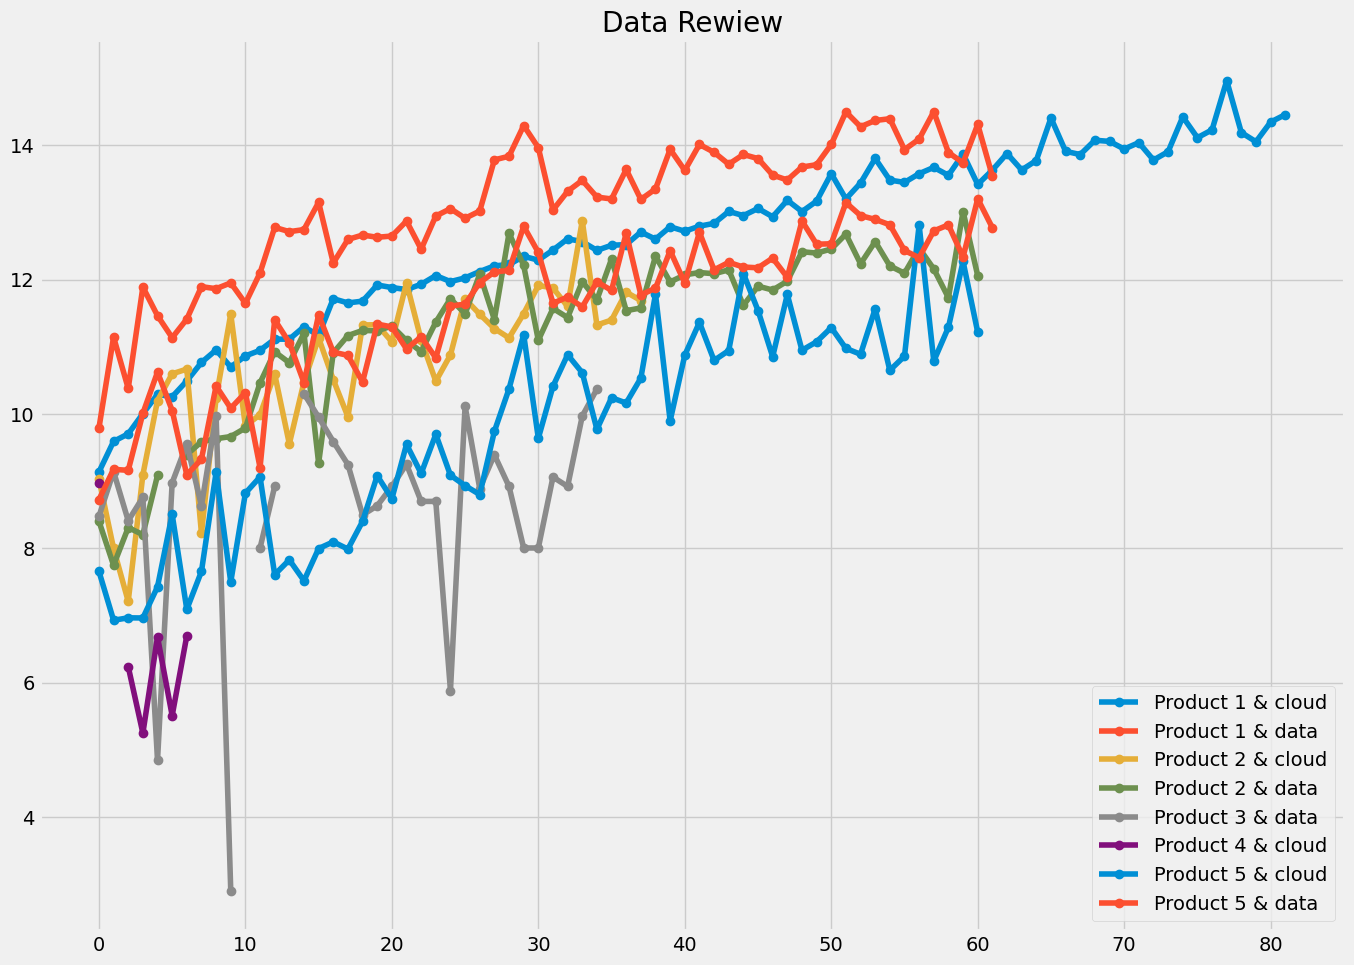

In [ ]:
plt.figure(figsize=(15, 11))
for key, data in data_dict.items():
  i, hosting = key.split('_')
  plt.plot(data_dict[key]['data']['log_revenue'], label=f'Product {i} & {hosting}', marker='o')

plt.title('Data Rewiew')
plt.legend()
plt.show()

## <font color='red'> **Raw data**

mape for product 1_cloud: 10.76
mape for product 1_data: 14.99
mape for product 2_cloud: 21.4
mape for product 2_data: 25.13
mape for product 3_data: 63.46
mape for product 4_cloud: 69.57
mape for product 5_cloud: 40.87
mape for product 5_data: 10.79


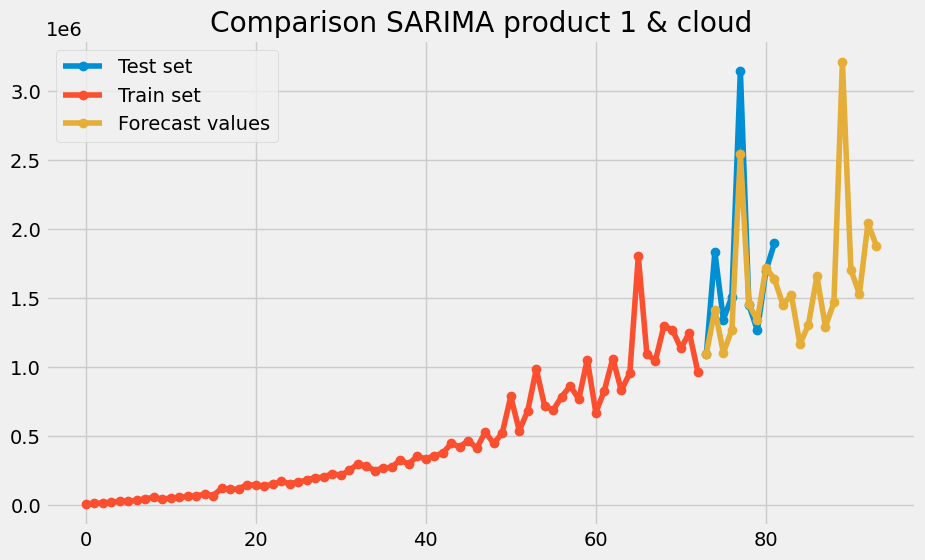

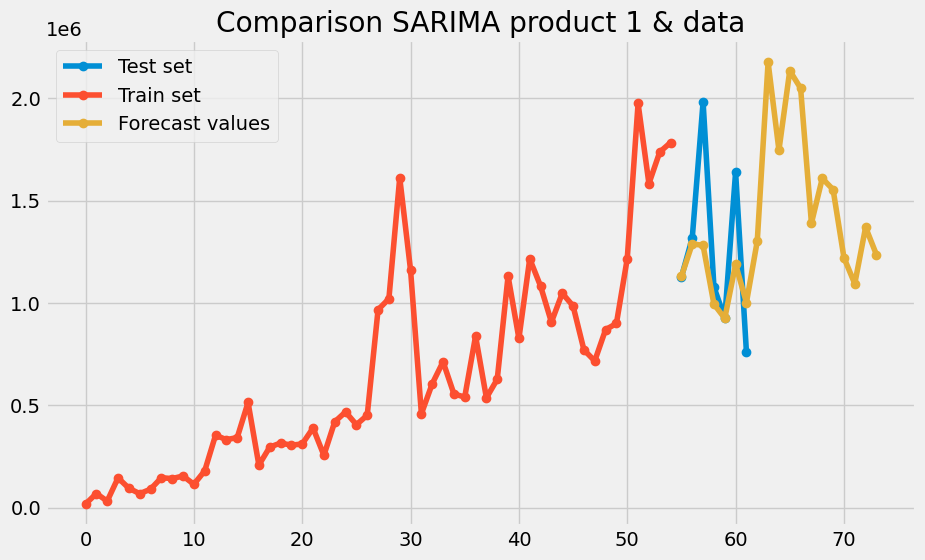

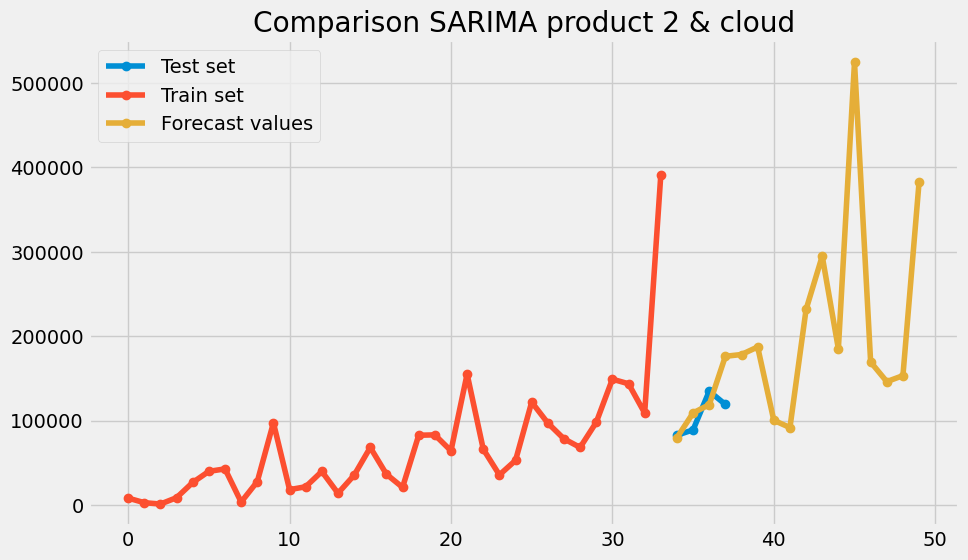

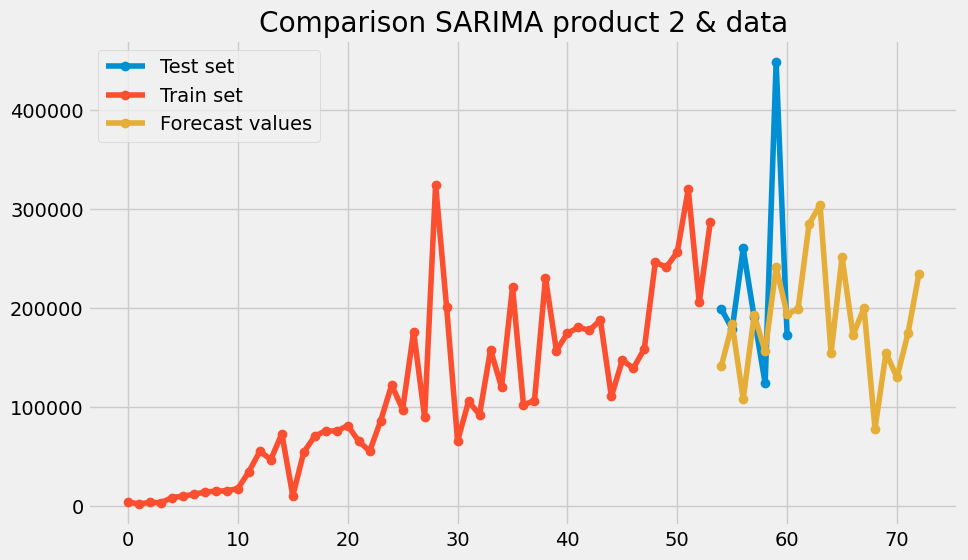

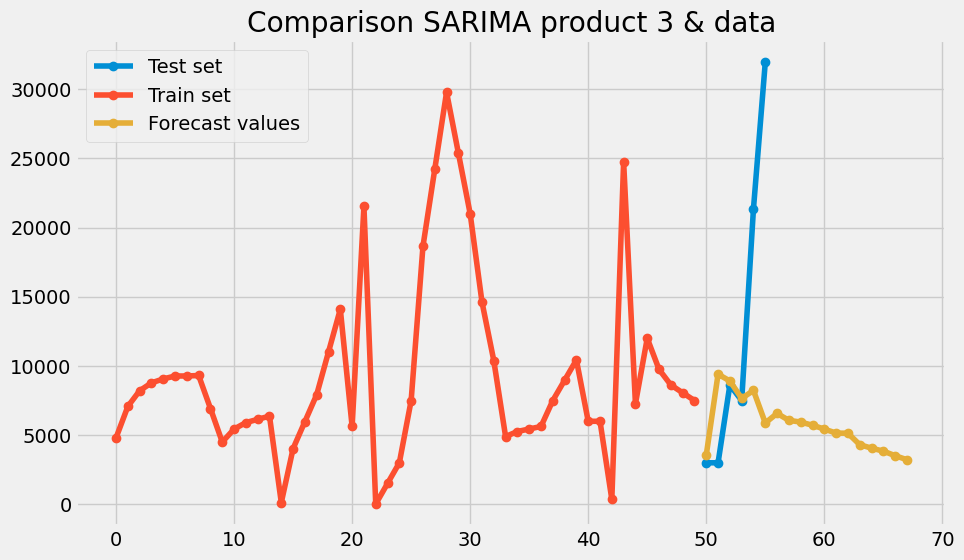

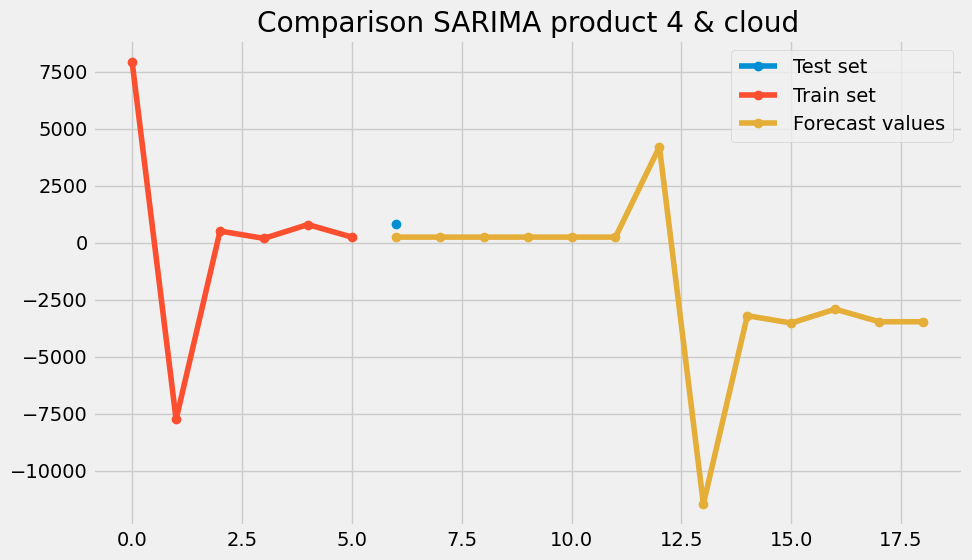

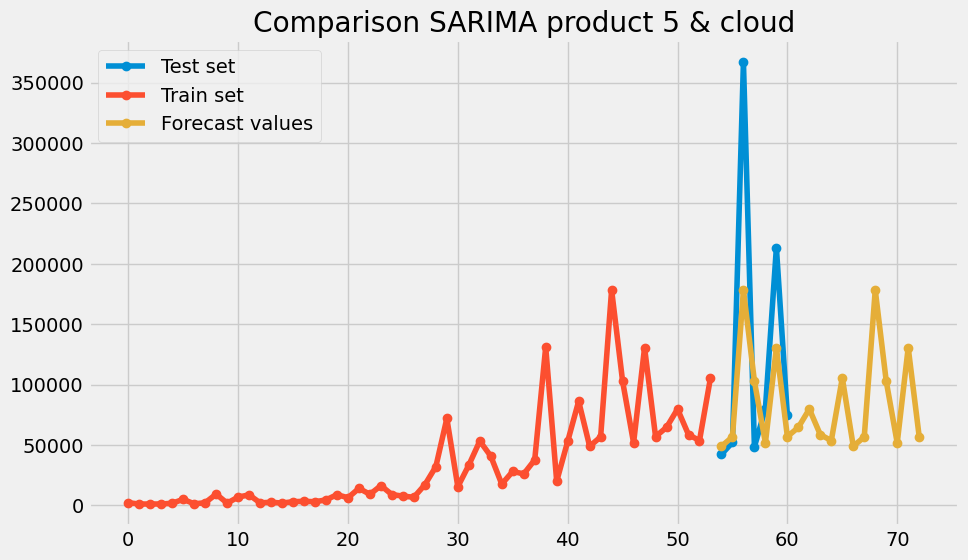

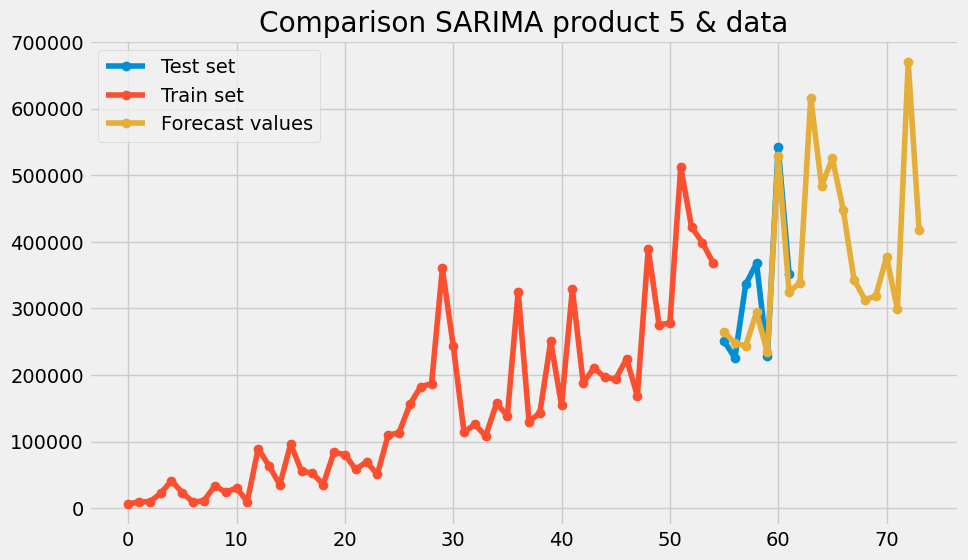

In [ ]:
for key, data in data_dict.items():
    i, hosting = key.split('_')
    mape_name = f"mape_{key}"
    plt_name = f"plt_{key}"
    globals()[mape_name], globals()[plt_name] = sarima(data_dict[key]['train'], data_dict[key]['test'], data_dict[key]['n_periods'], i, hosting,
                            data_dict[key]['params']['q'], data_dict[key]['params']['d'], data_dict[key]['params']['r'], data_dict[key]['params']['Q'], data_dict[key]['params']['D'], data_dict[key]['params']['R'], False )
for key, data in data_dict.items():
    mape_name = f"mape_{key}"
    mape_value = round(globals()[mape_name], 2)
    print(f"mape for product {key}: {mape_value}")

for key, data in data_dict.items():
  plt_name = f"plt_{key}"
  globals()[plt_name].show()

## <font color='red'> **CV**

Fold 1: Train data from 0 to 16, Test data from 17 to 29
MAPE for product 1, hosting cloud, Fold 1: 170.73
Fold 2: Train data from 0 to 29, Test data from 30 to 42
MAPE for product 1, hosting cloud, Fold 2: 91.85
Fold 3: Train data from 0 to 42, Test data from 43 to 55
MAPE for product 1, hosting cloud, Fold 3: 12.44
Fold 4: Train data from 0 to 55, Test data from 56 to 68
MAPE for product 1, hosting cloud, Fold 4: 18.7
Fold 5: Train data from 0 to 68, Test data from 69 to 81
MAPE for product 1, hosting cloud, Fold 5: 20.09
Fold 1: Train data from 0 to 11, Test data from 12 to 21
MAPE for product 1, hosting data, Fold 1: nan
Fold 2: Train data from 0 to 21, Test data from 22 to 31
MAPE for product 1, hosting data, Fold 2: nan
Fold 3: Train data from 0 to 31, Test data from 32 to 41
MAPE for product 1, hosting data, Fold 3: 42.54
Fold 4: Train data from 0 to 41, Test data from 42 to 51
MAPE for product 1, hosting data, Fold 4: 212.32
Fold 5: Train data from 0 to 51, Test data from 52 to

<ipython-input-13-25d3a0c23b18>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
<ipython-input-16-2c0f2ff398a2>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


Fold 4: Train data from 0 to 24, Test data from 25 to 29
MAPE for product 3, hosting data, Fold 4: 357.51
Fold 5: Train data from 0 to 29, Test data from 30 to 34
MAPE for product 3, hosting data, Fold 5: 54.27
Fold 1: Train data from 0 to 1, Test data from 2 to 2
MAPE for product 4, hosting cloud, Fold 1: 1608.94
Fold 2: Train data from 0 to 2, Test data from 3 to 3
MAPE for product 4, hosting cloud, Fold 2: 169.48
Fold 3: Train data from 0 to 3, Test data from 4 to 4
MAPE for product 4, hosting cloud, Fold 3: 76.14
Fold 4: Train data from 0 to 4, Test data from 5 to 5
MAPE for product 4, hosting cloud, Fold 4: 222.78
Fold 5: Train data from 0 to 5, Test data from 6 to 6
MAPE for product 4, hosting cloud, Fold 5: 69.57
Fold 1: Train data from 0 to 10, Test data from 11 to 20
MAPE for product 5, hosting cloud, Fold 1: 58.46
Fold 2: Train data from 0 to 20, Test data from 21 to 30
MAPE for product 5, hosting cloud, Fold 2: 71.49
Fold 3: Train data from 0 to 30, Test data from 31 to 40
M

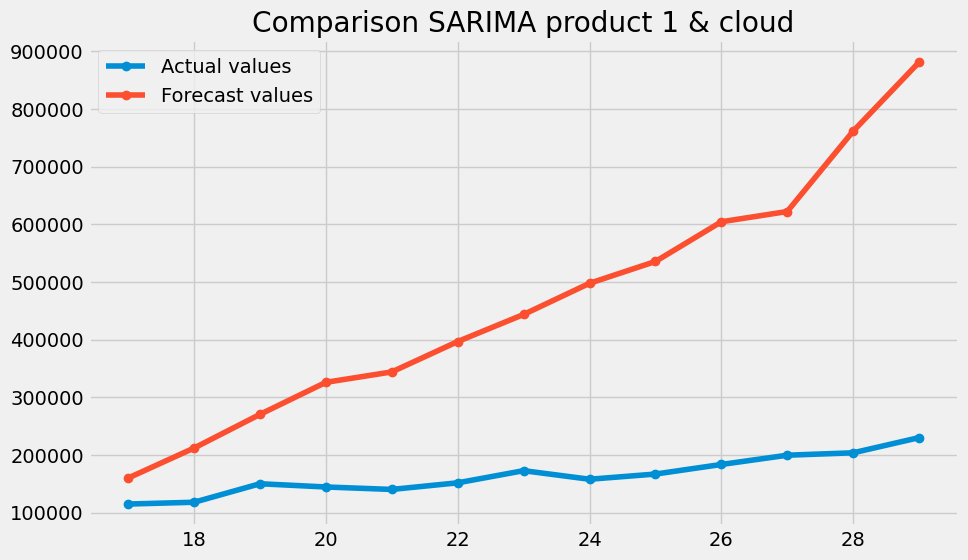

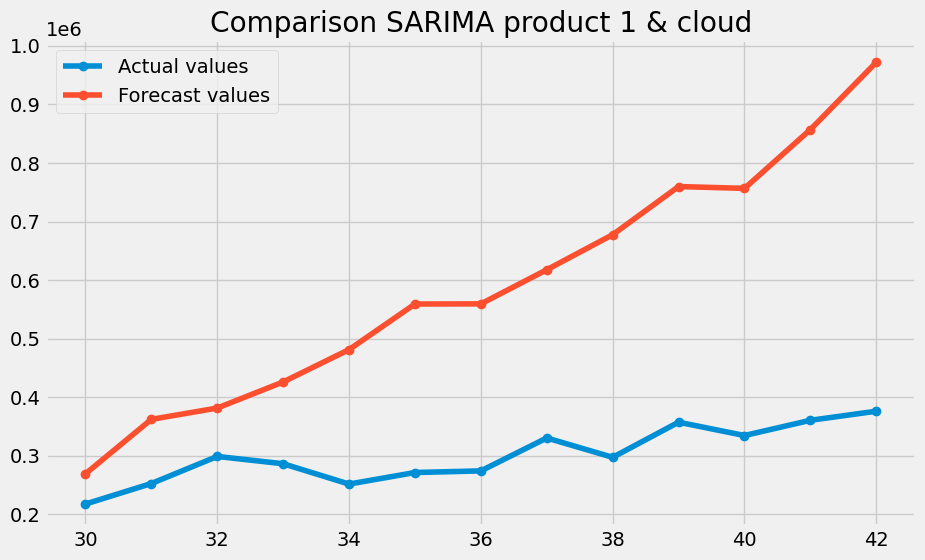

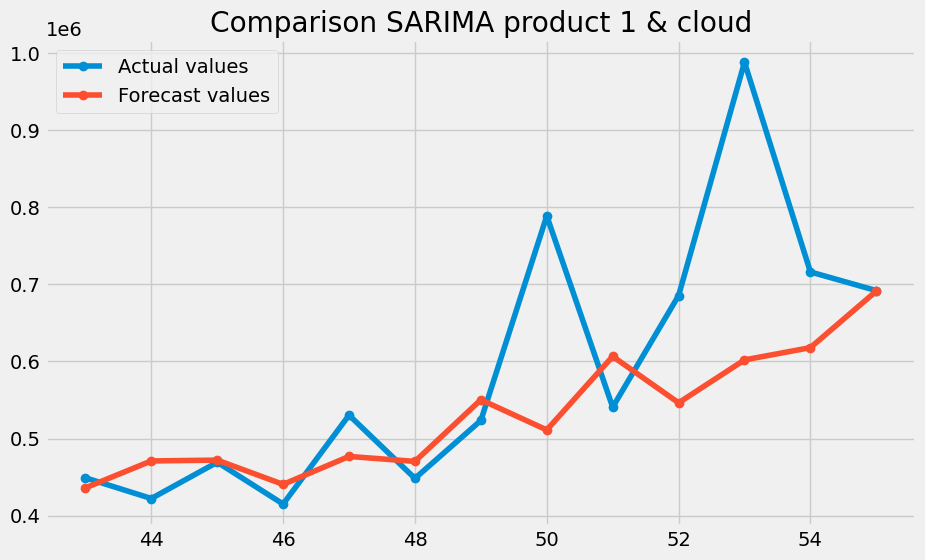

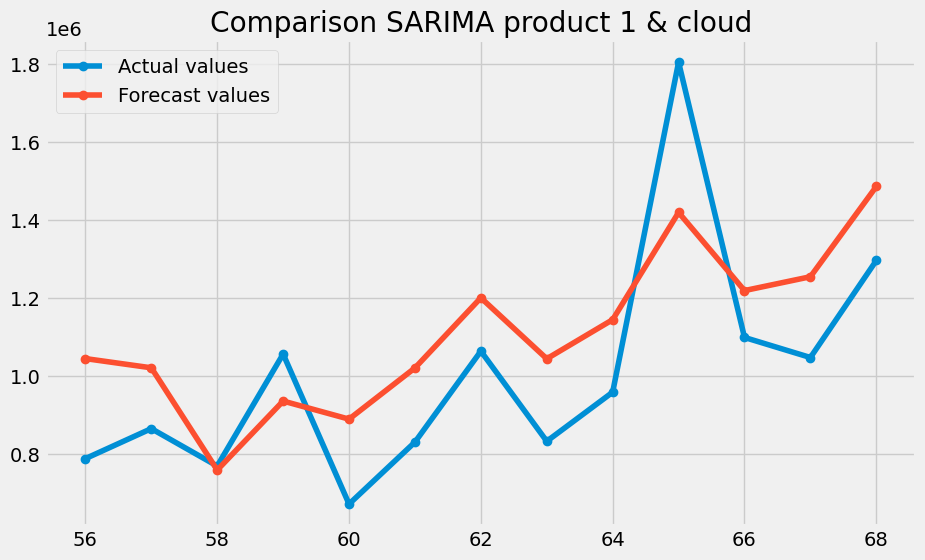

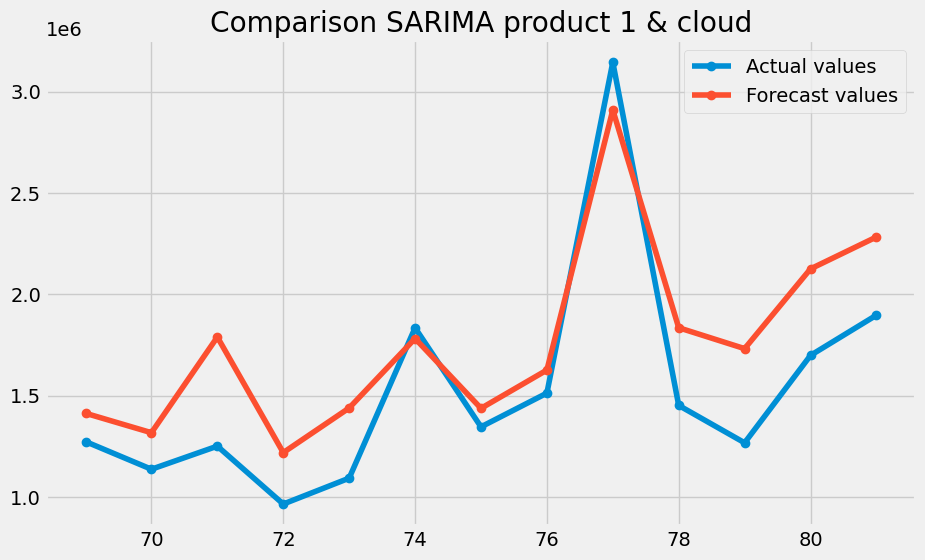

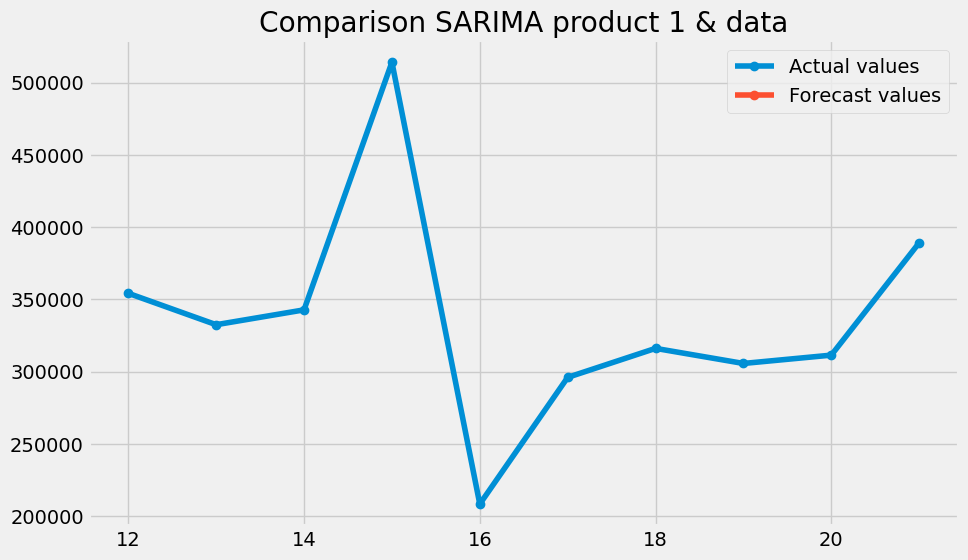

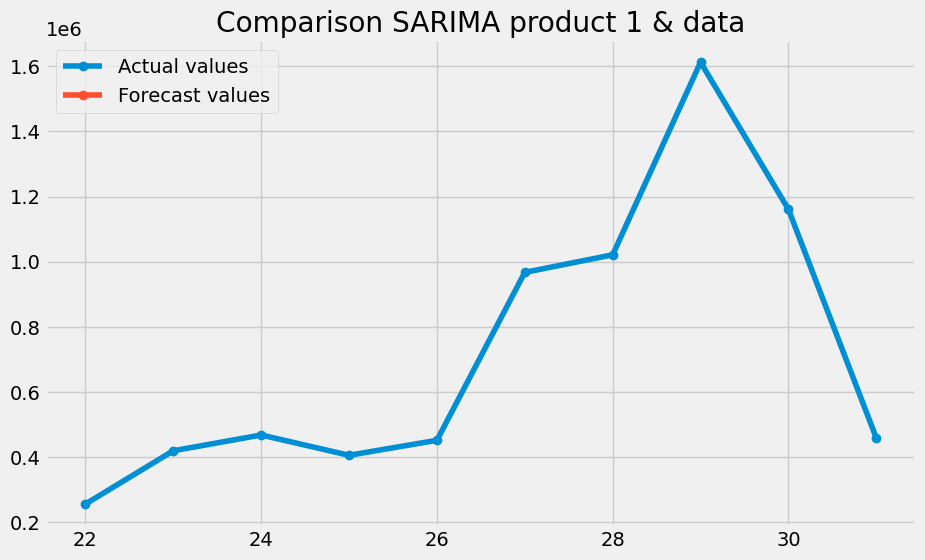

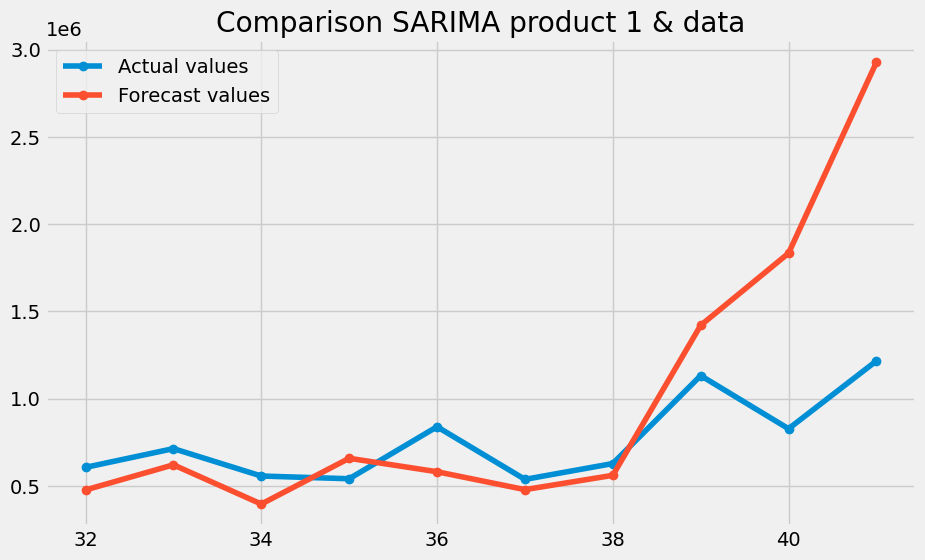

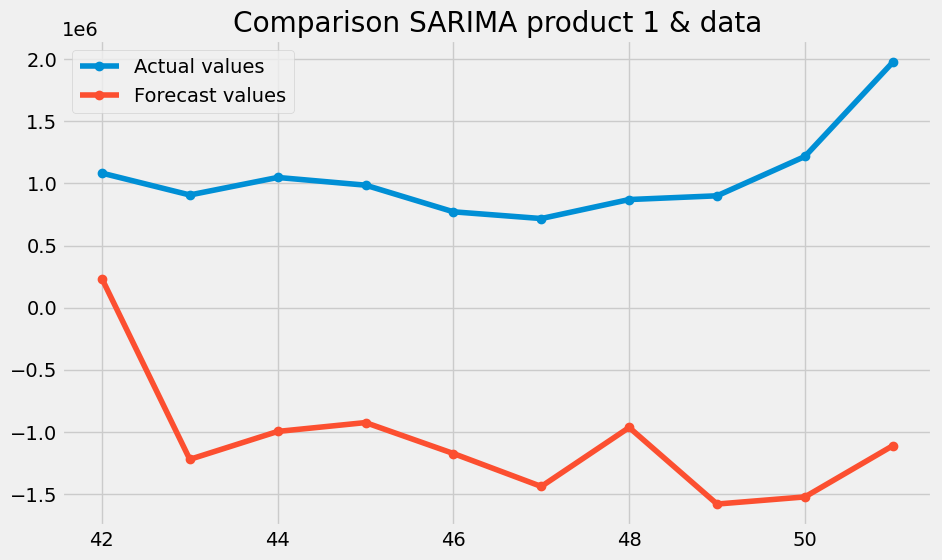

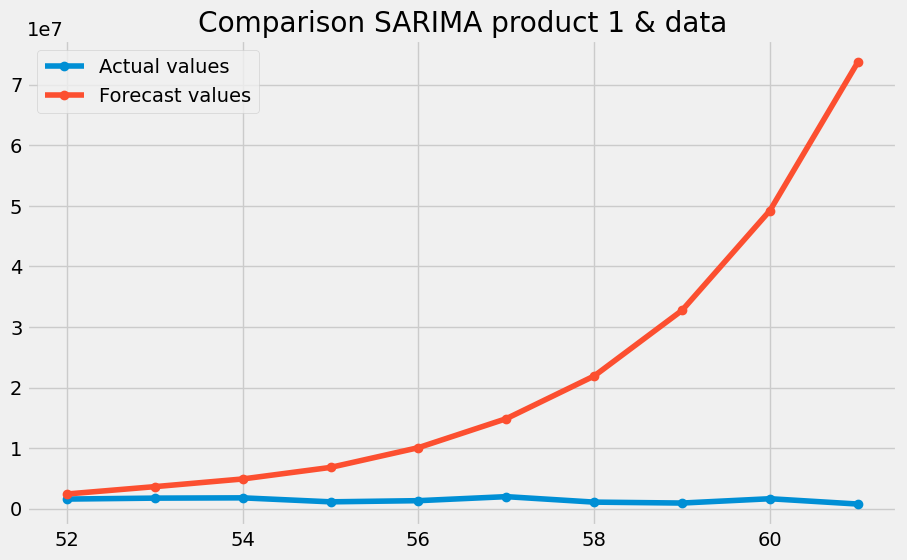

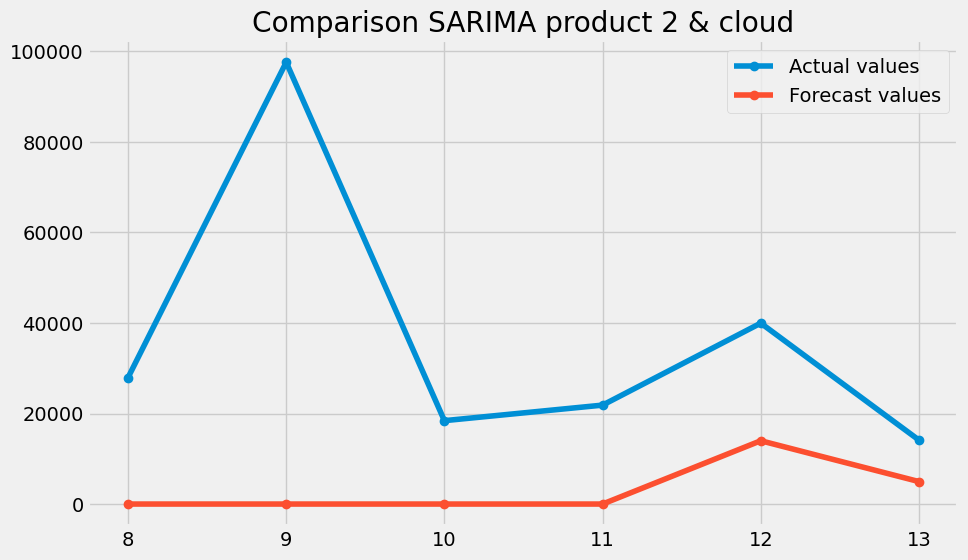

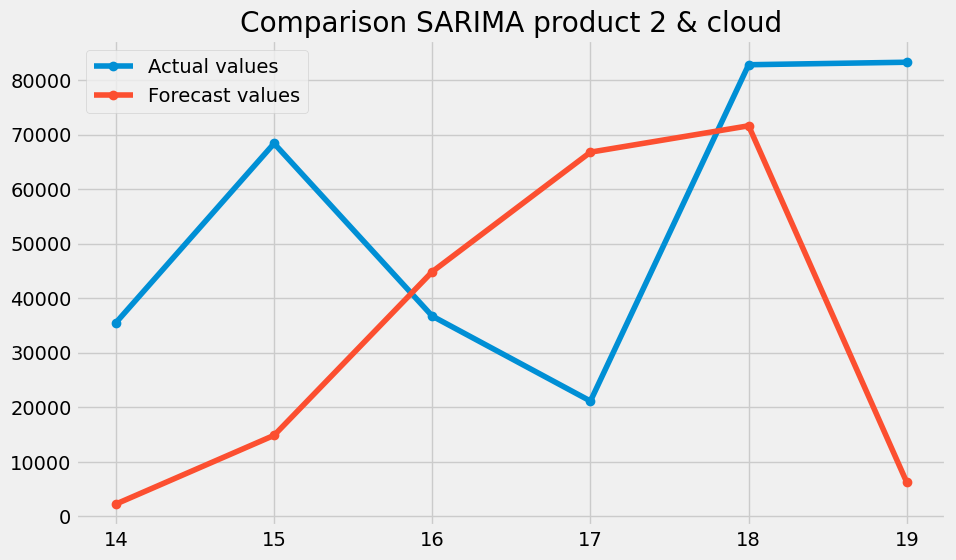

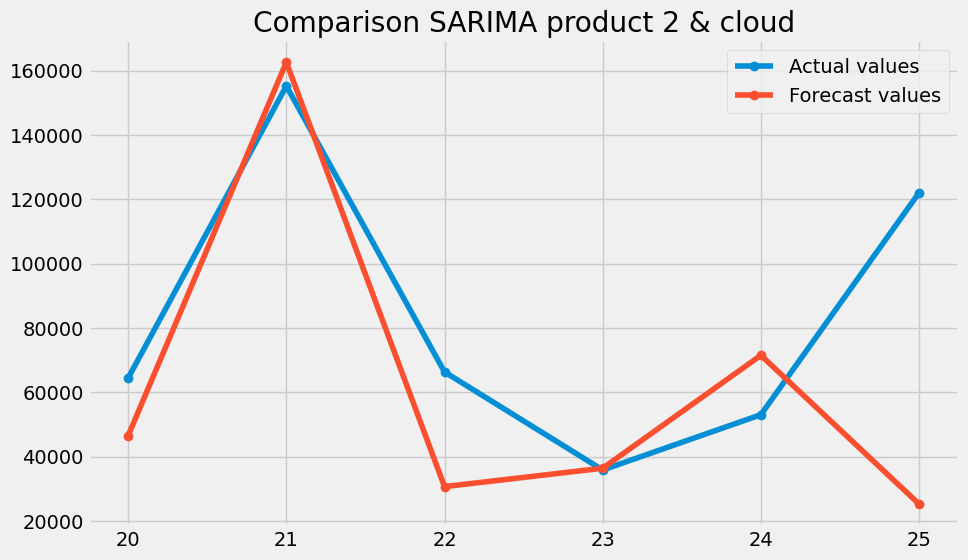

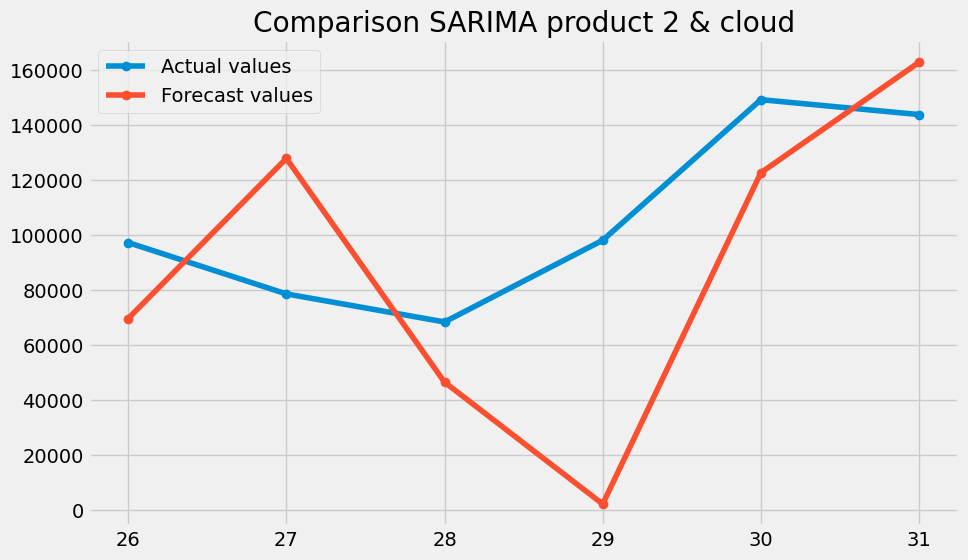

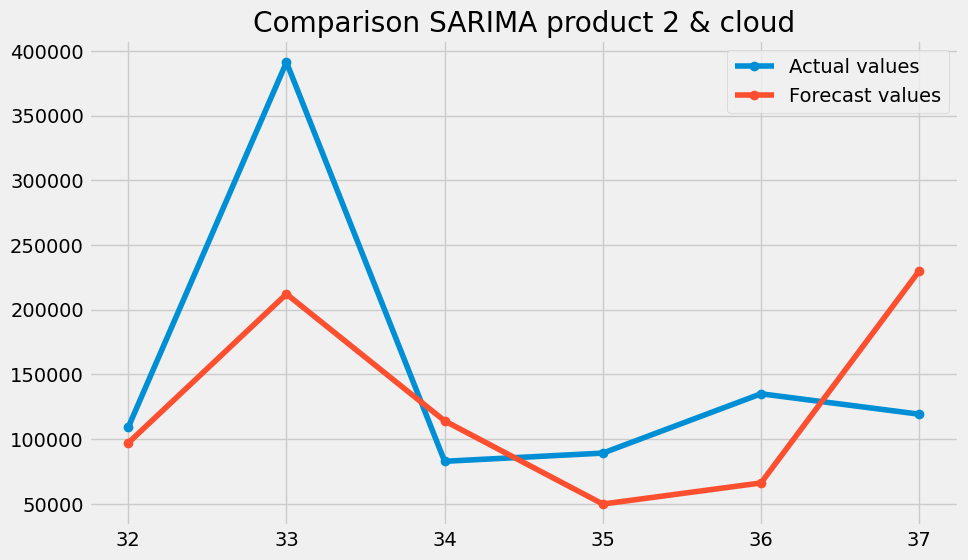

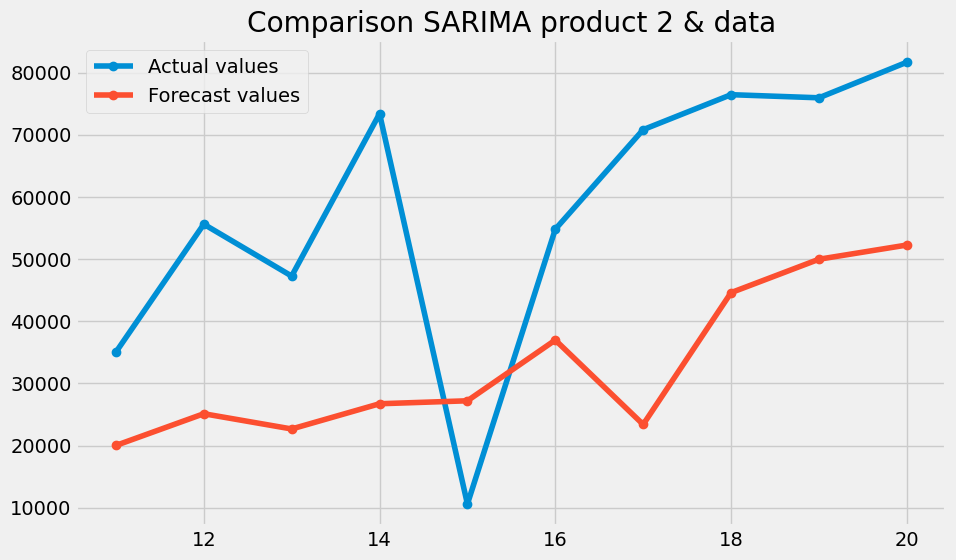

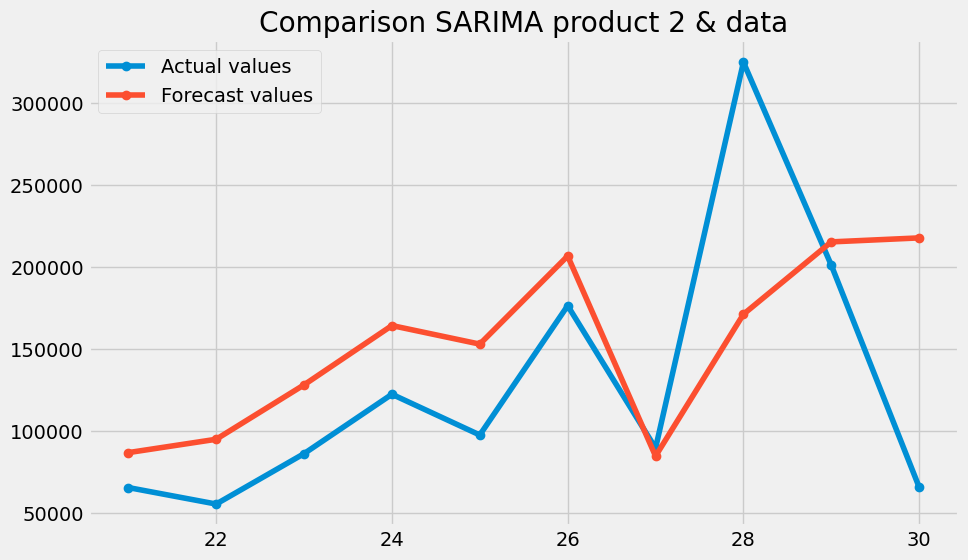

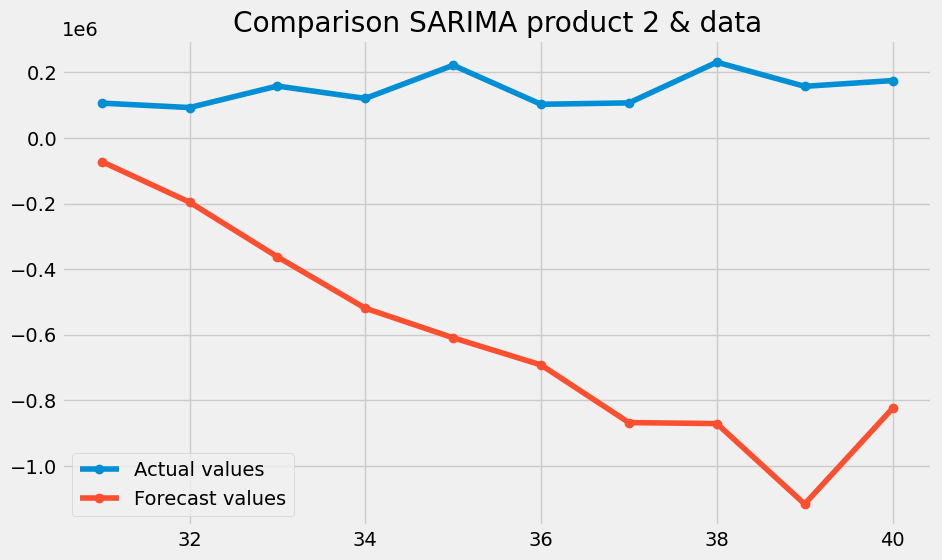

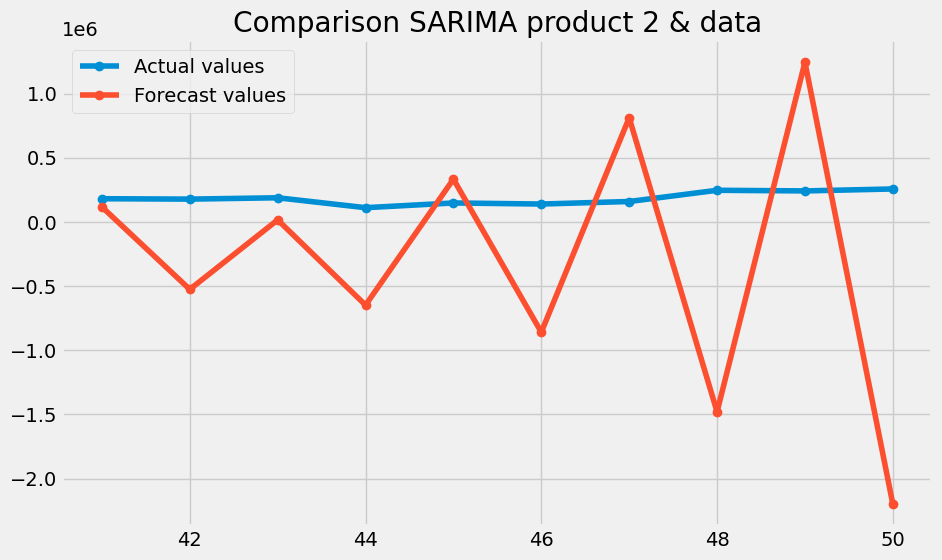

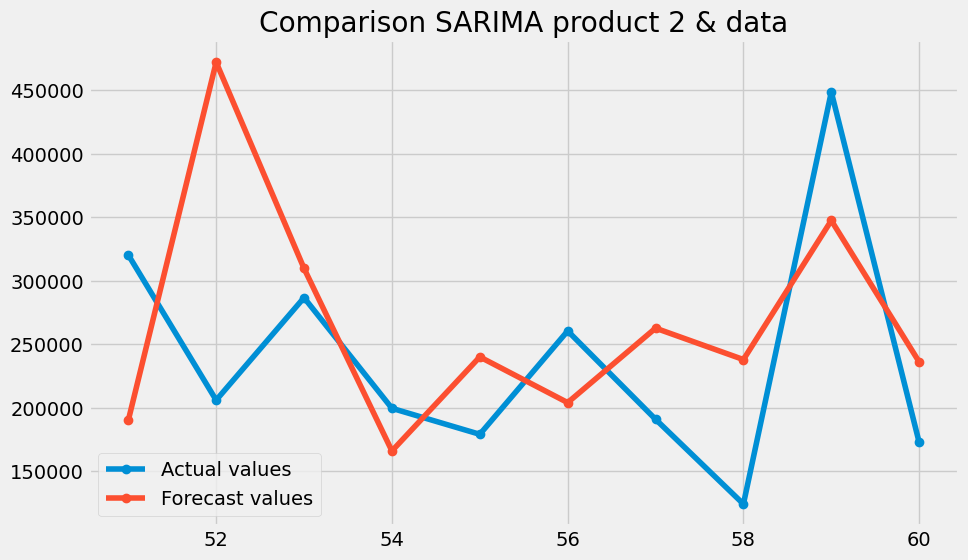

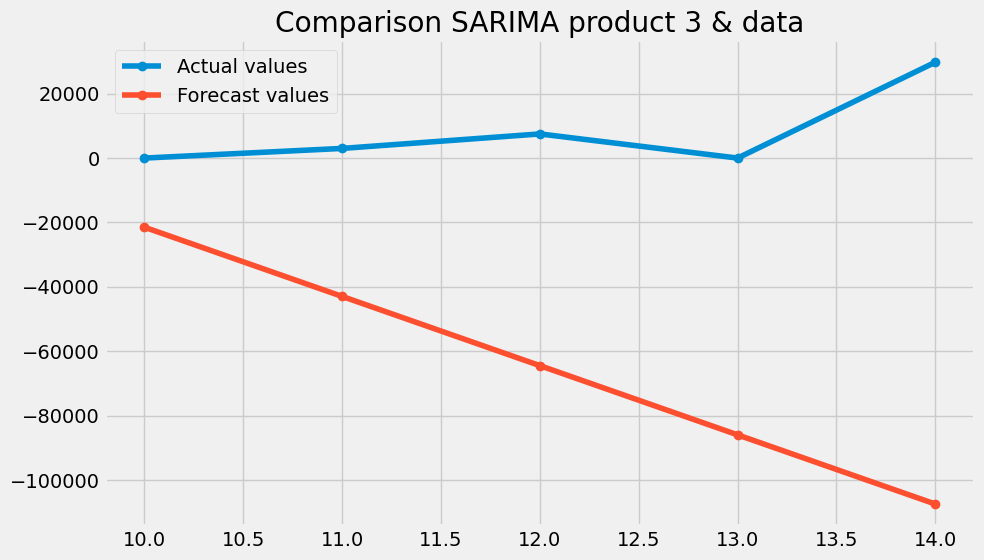

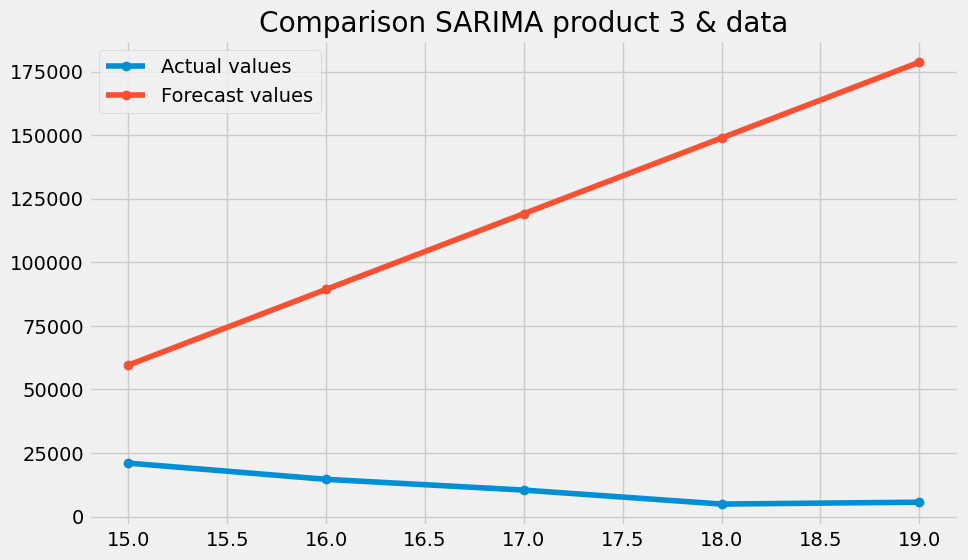

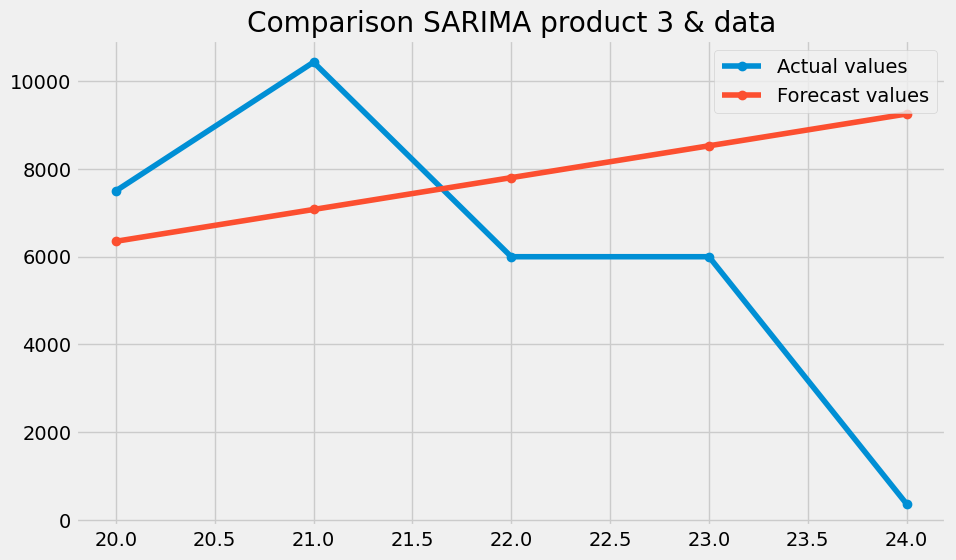

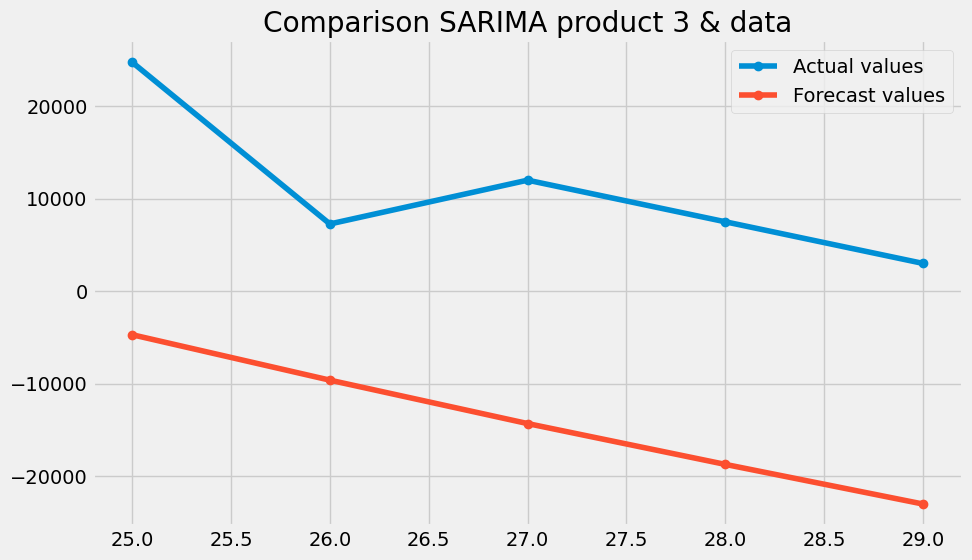

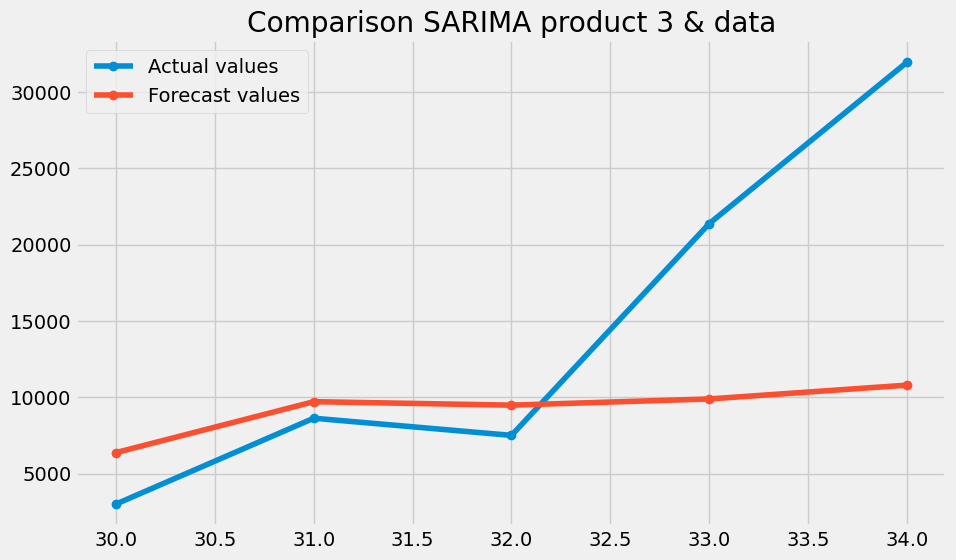

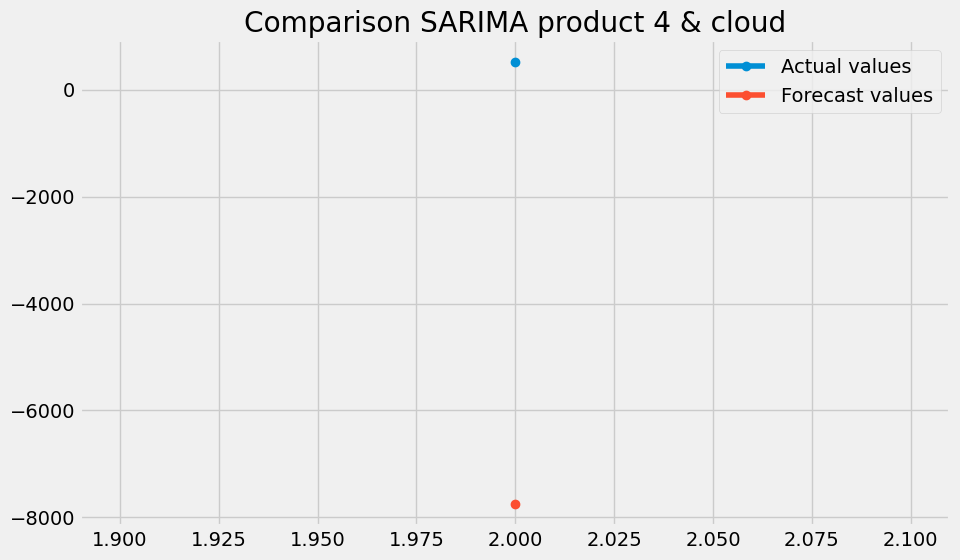

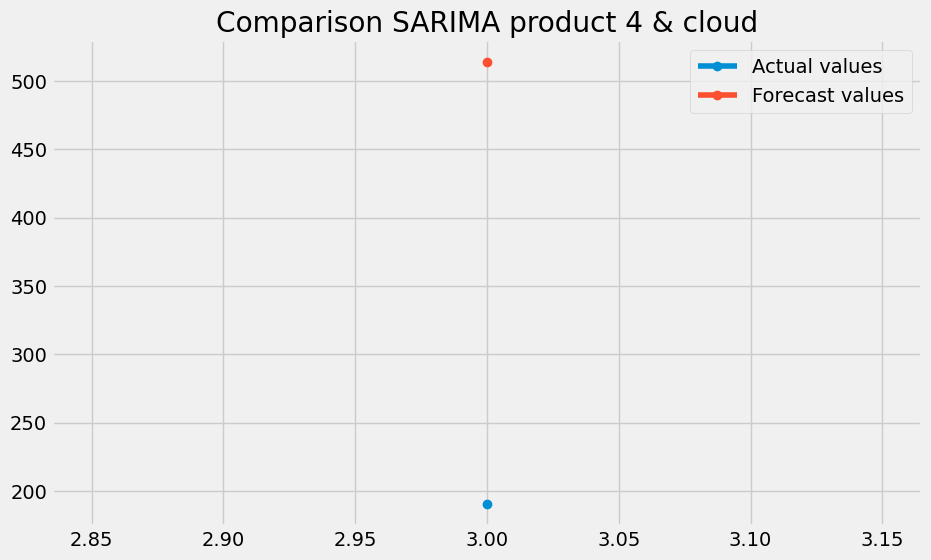

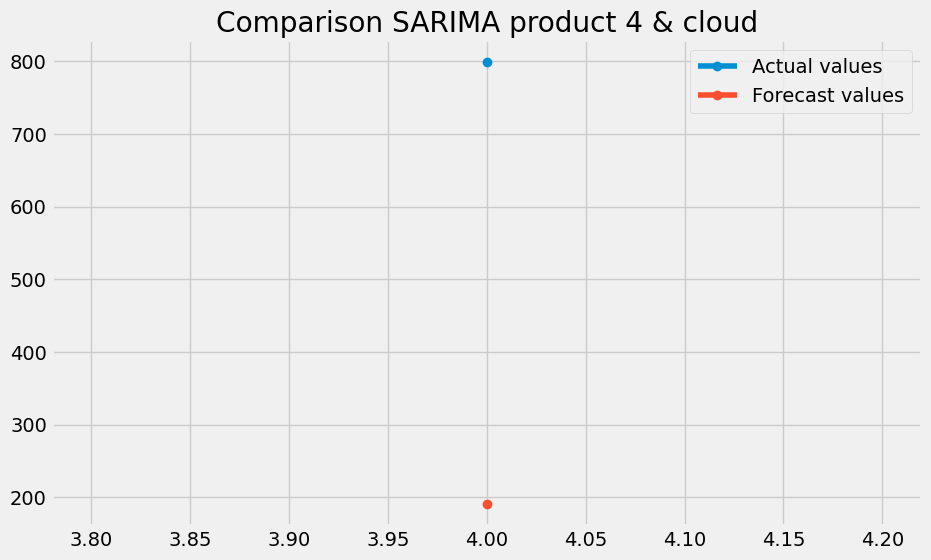

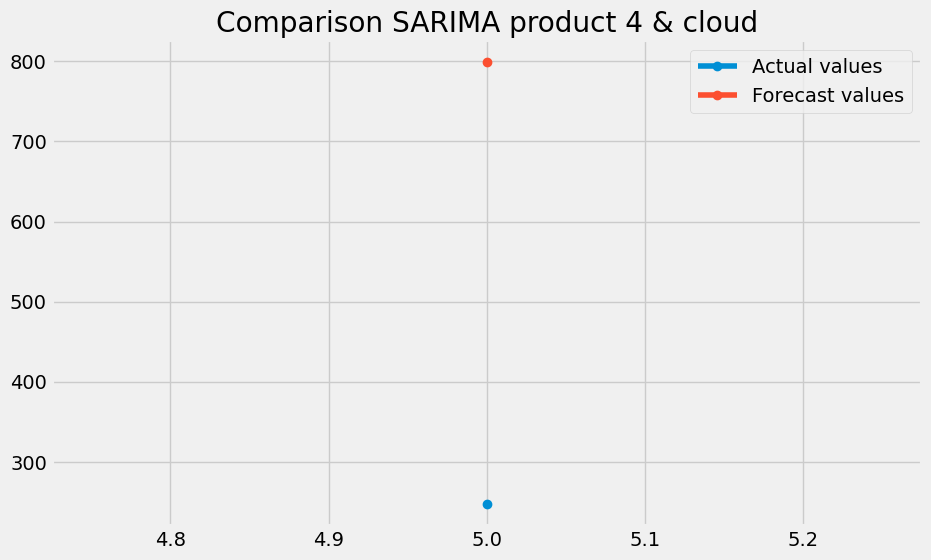

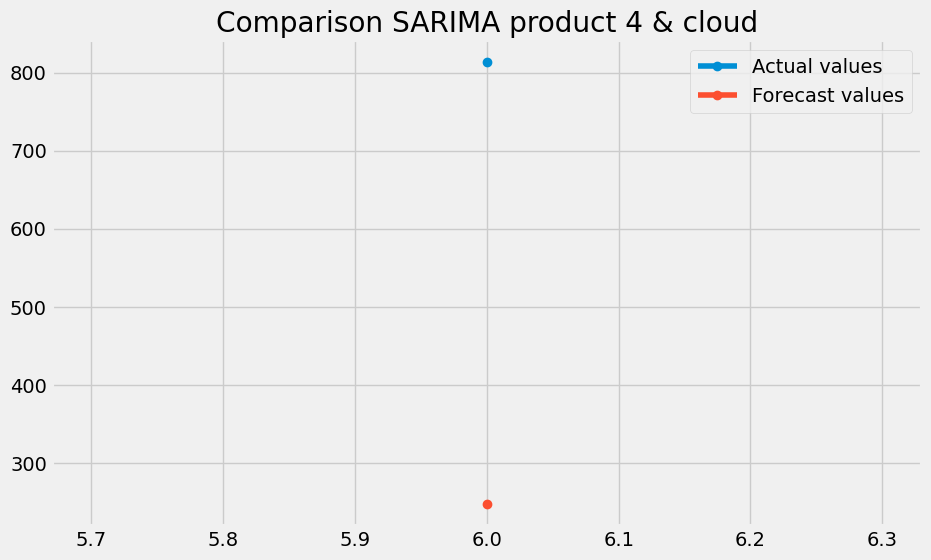

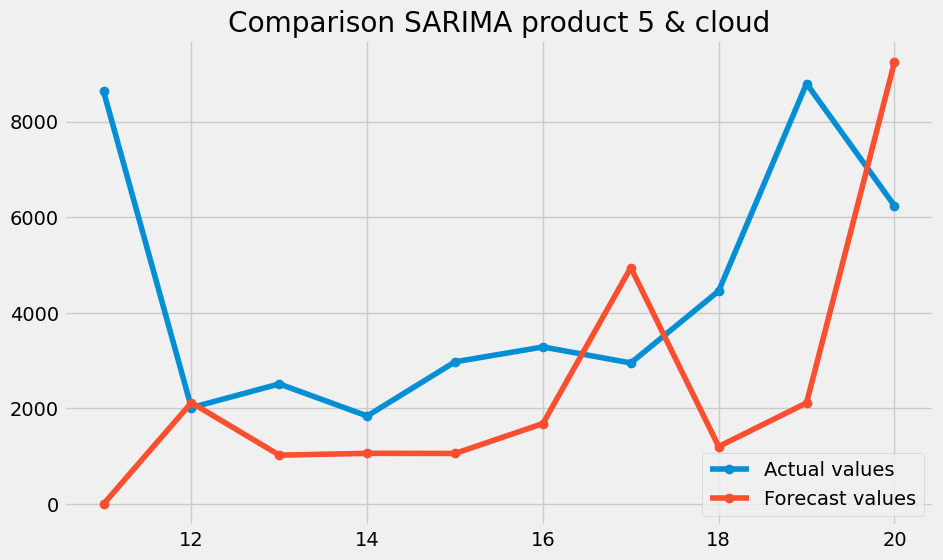

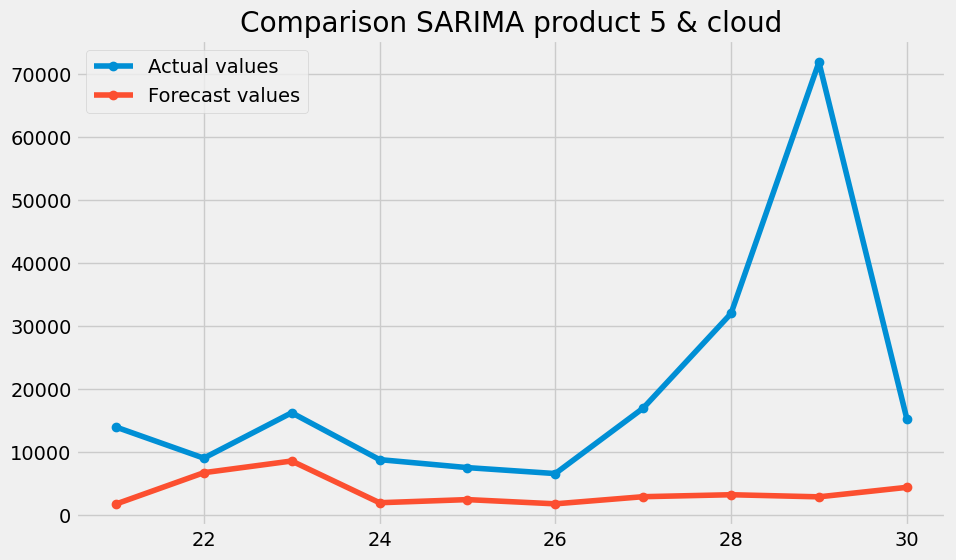

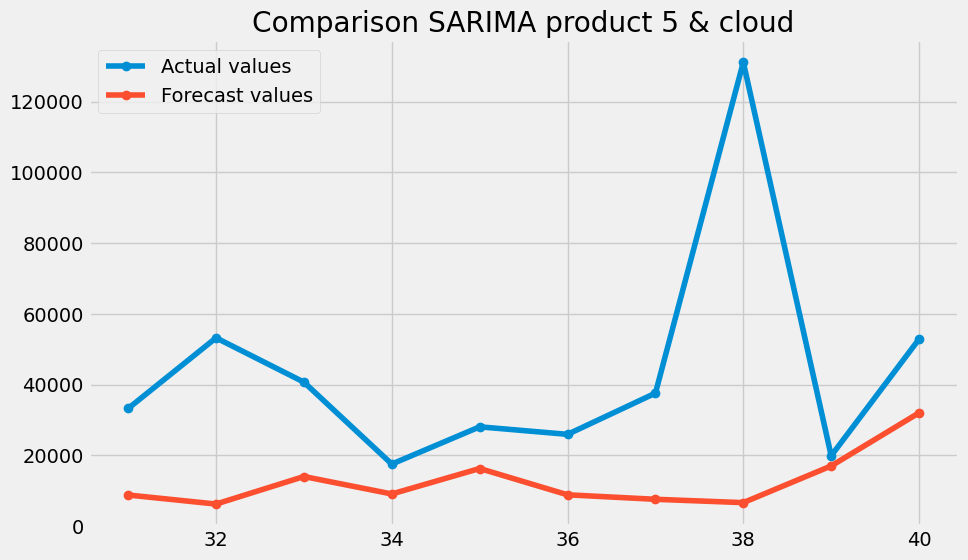

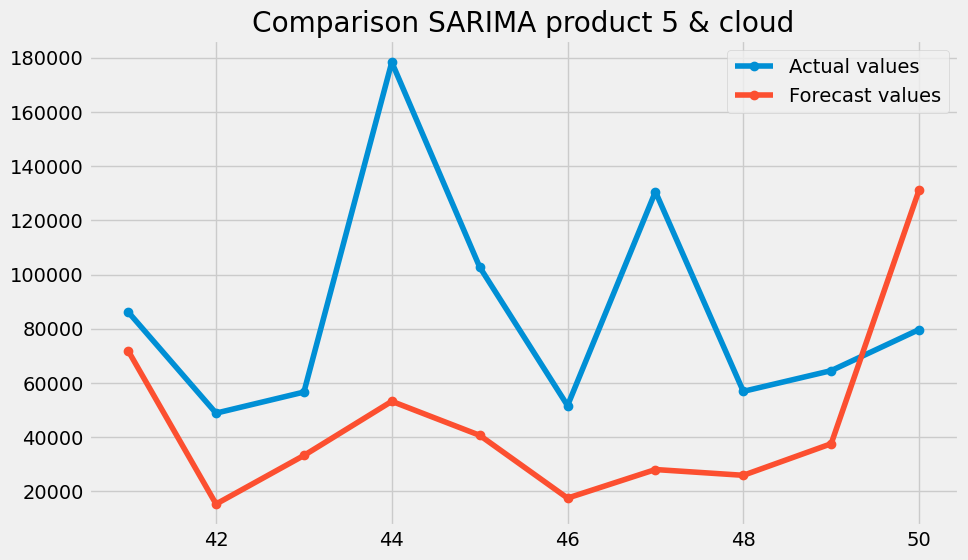

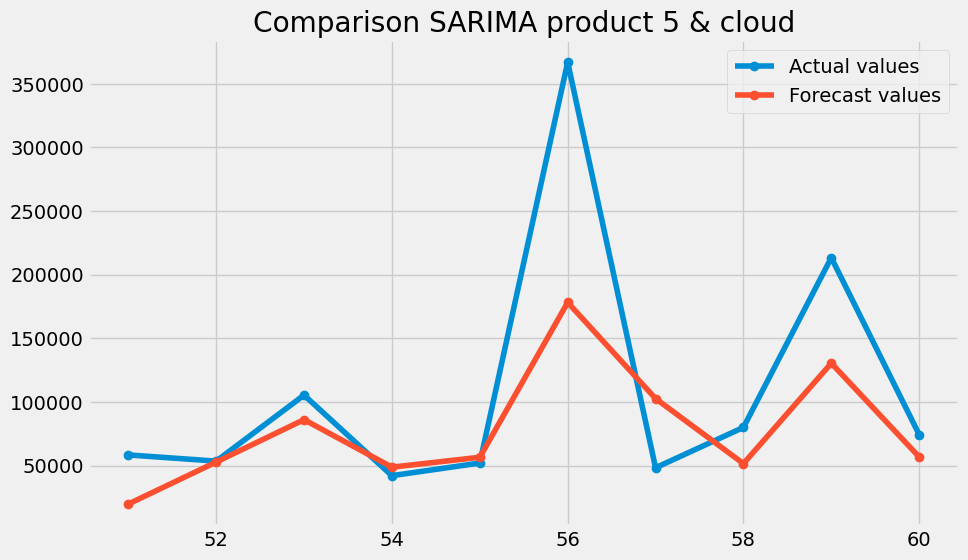

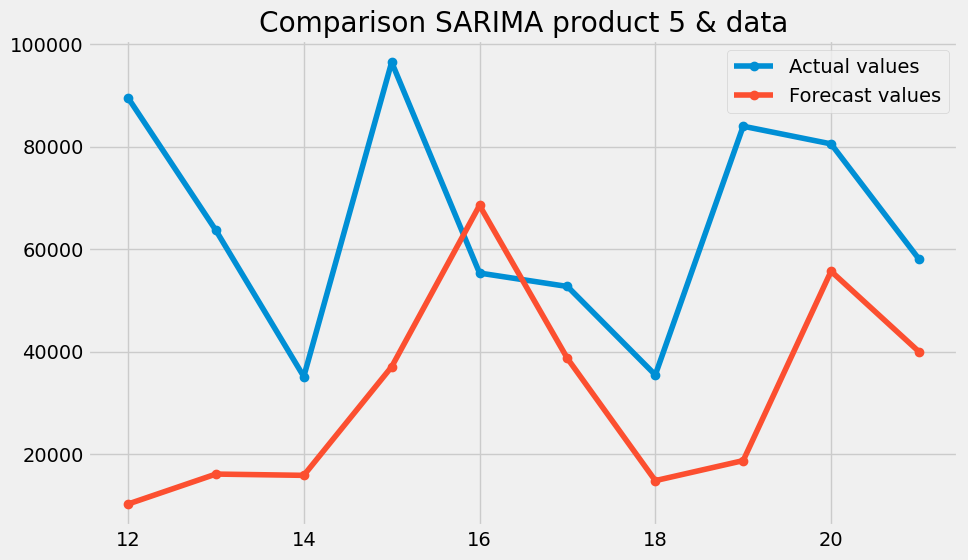

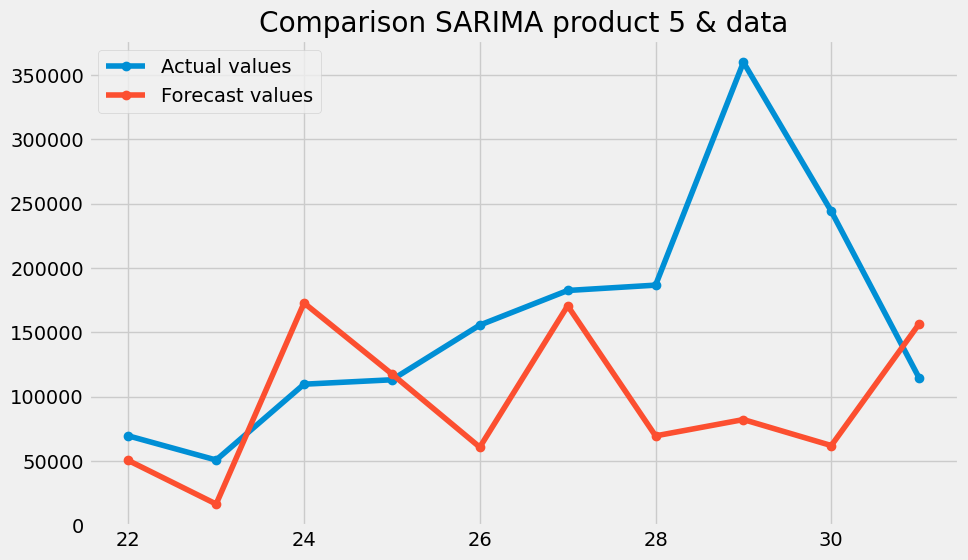

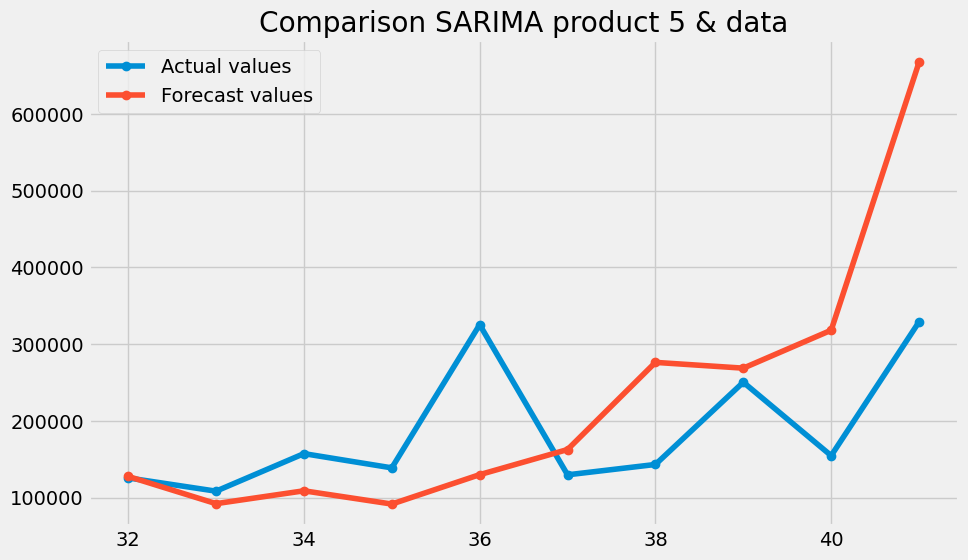

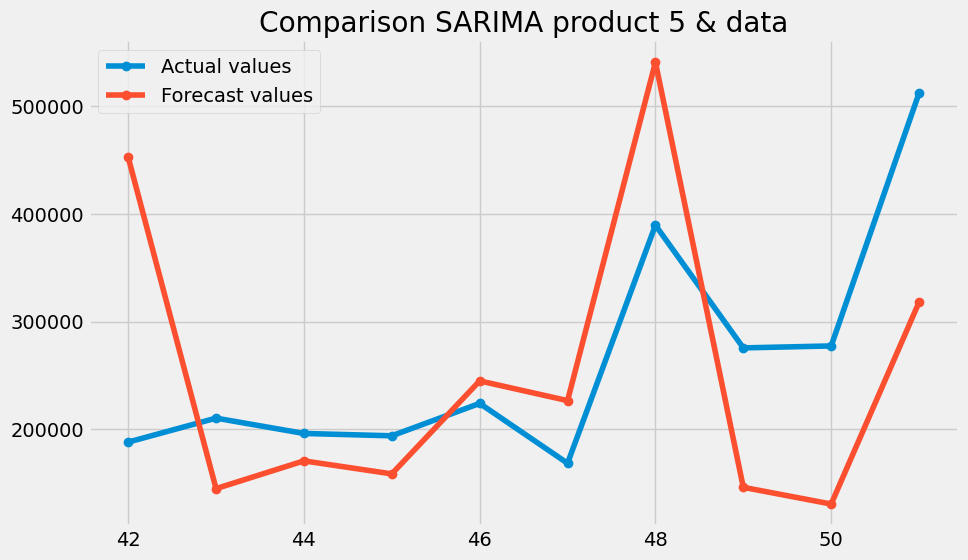

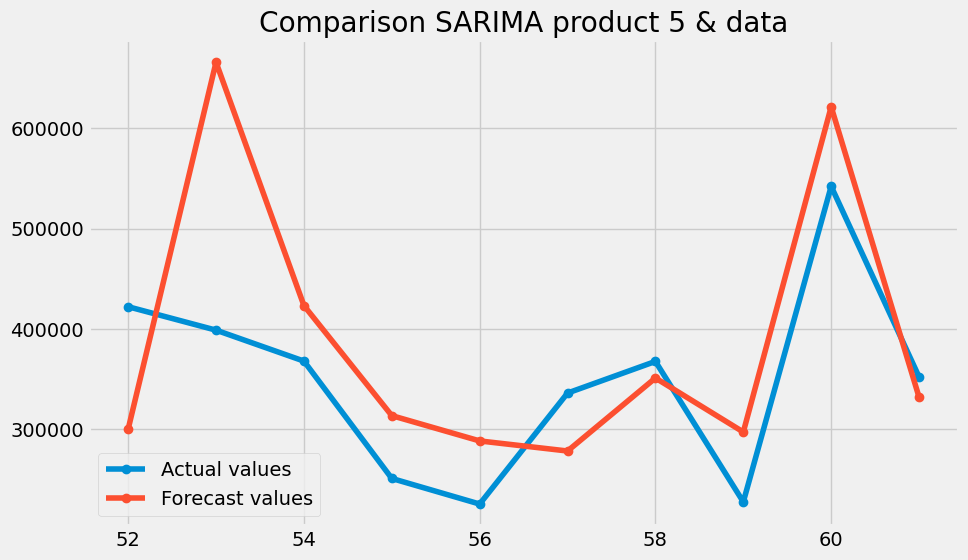

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

for key, data in data_dict.items():
    i, hosting = key.split('_')


    for fold, (train_index, test_index) in enumerate(tscv.split(data_dict[key]['data']), 1):
        train_data, test_data = data_dict[key]['data'].iloc[train_index], data_dict[key]['data'].iloc[test_index]

        mape, plt = sarima(train_data, test_data, len(test_data), i, hosting,
                         data_dict[key]['params']['q'], data_dict[key]['params']['d'], data_dict[key]['params']['r'], data_dict[key]['params']['Q'], data_dict[key]['params']['D'], data_dict[key]['params']['R'], False, True)

        print(f"Fold {fold}: Train data from {train_data.index.min()} to {train_data.index.max()}, Test data from {test_data.index.min()} to {test_data.index.max()}")

        print(f"MAPE for product {i}, hosting {hosting}, Fold {fold}: {round(mape, 2)}")


## <font color='red'> **LOG**

mape for product 1_cloud: 10.98
mape for product 1_data: 15.46
mape for product 2_cloud: 61.64
mape for product 2_data: 24.59
mape for product 3_data: 50.13
mape for product 4_cloud: 69.57
mape for product 5_cloud: 37.53
mape for product 5_data: 14.45


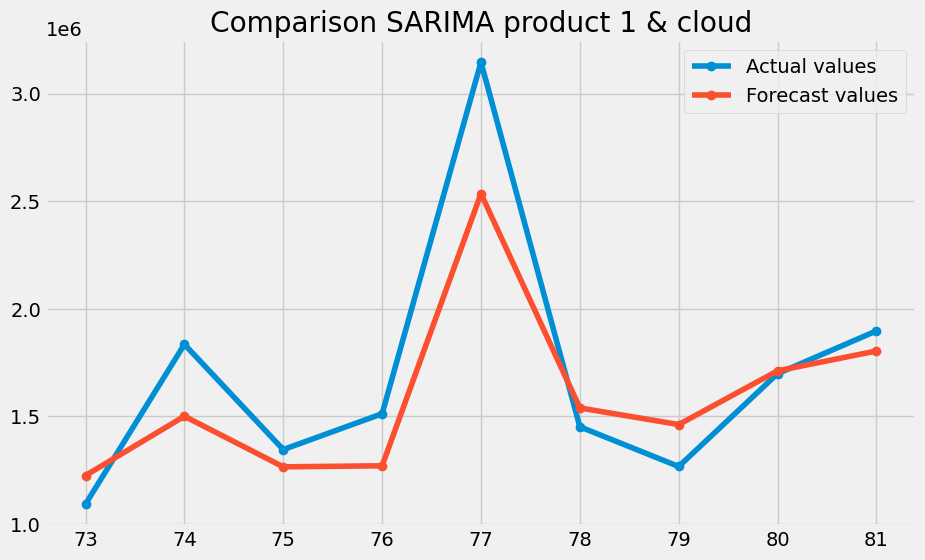

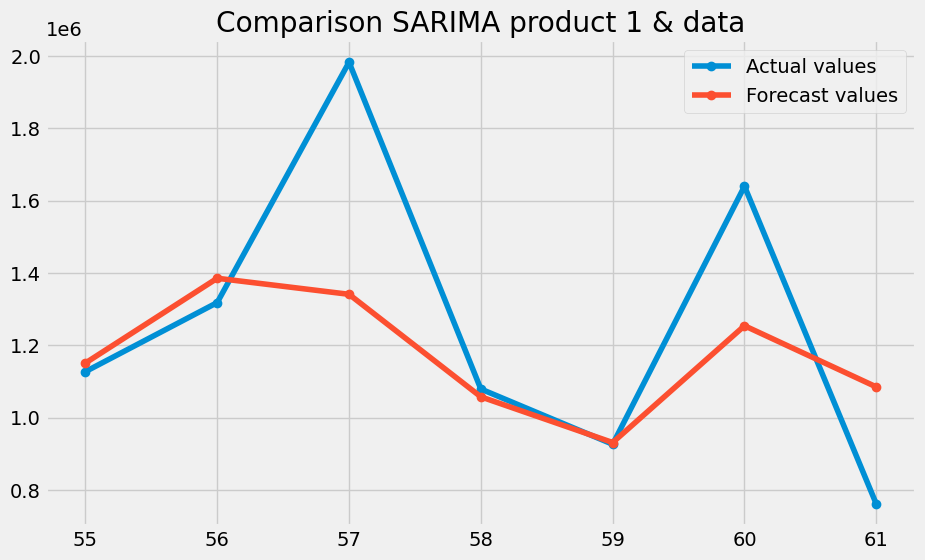

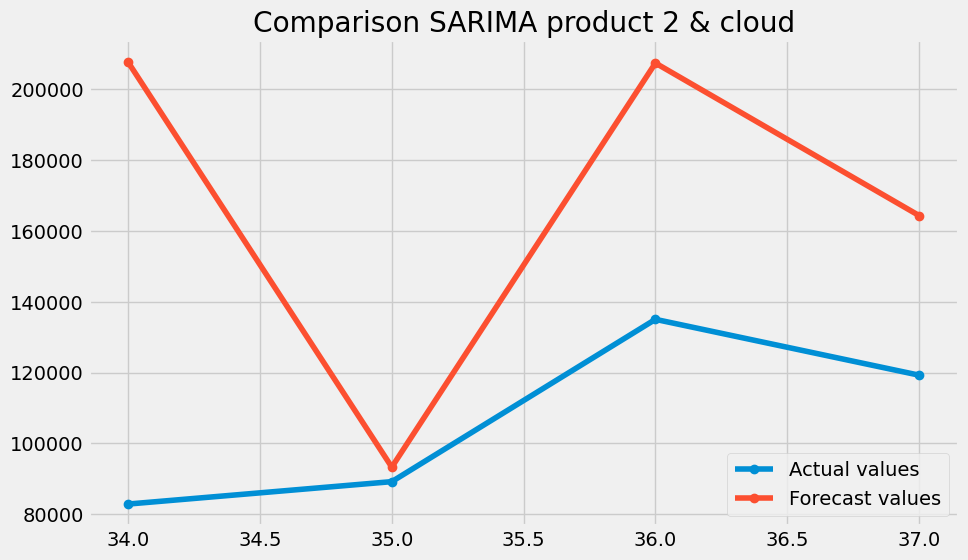

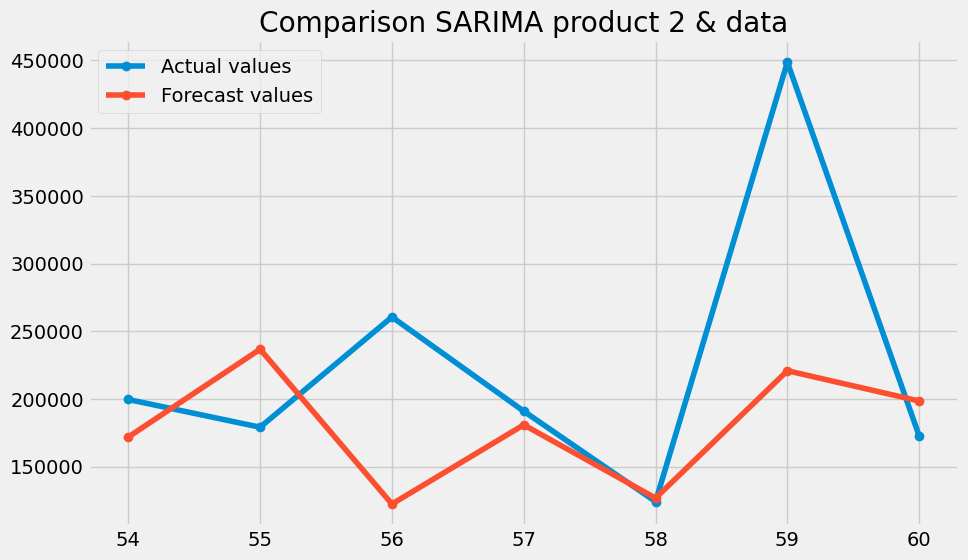

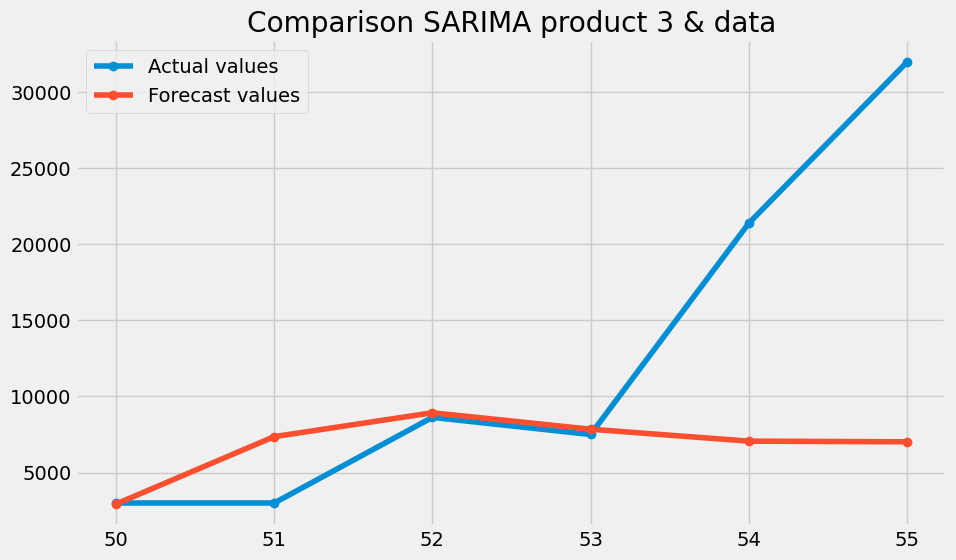

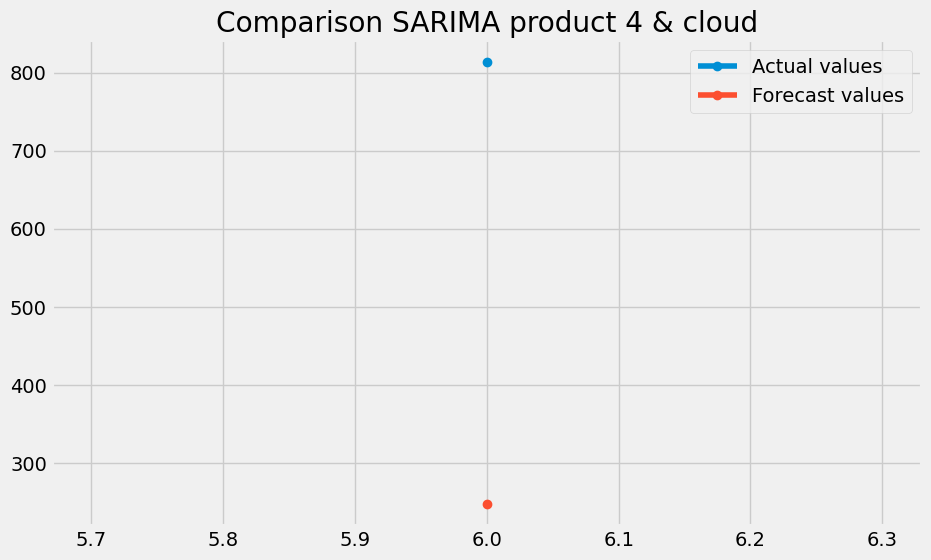

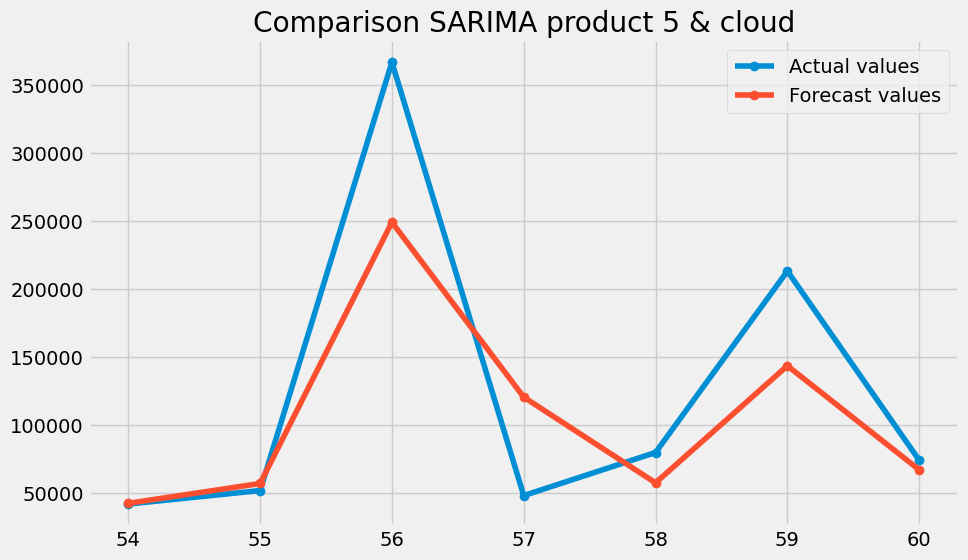

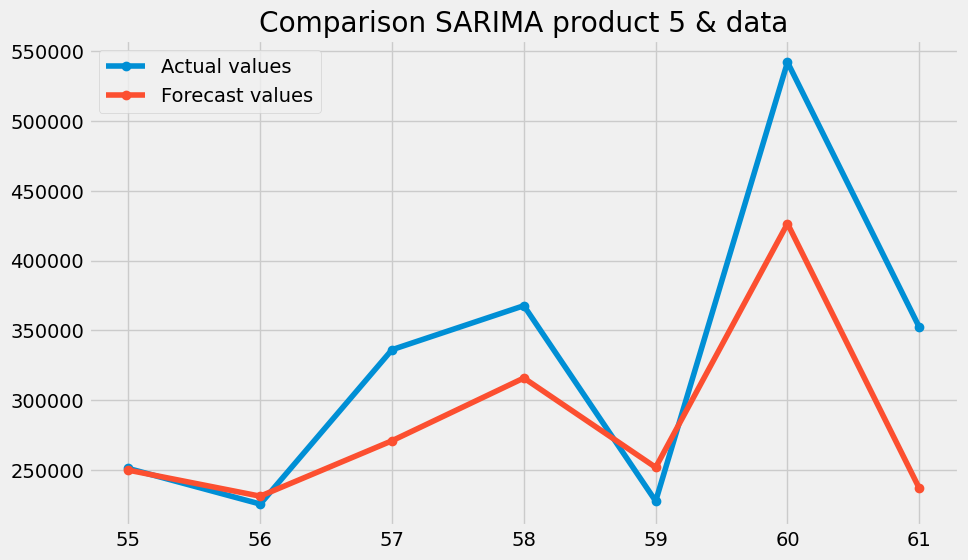

In [ ]:
for key, data in data_dict.items():
    i, hosting = key.split('_')
    mape_name = f"mape_{key}"
    plt_name = f"plt_{key}"
    globals()[mape_name], globals()[plt_name] = sarima(data_dict[key]['train'], data_dict[key]['test'], data_dict[key]['n_periods'], i, hosting,
                            data_dict[key]['log_params']['q'], data_dict[key]['log_params']['d'], data_dict[key]['log_params']['r'], data_dict[key]['log_params']['Q'], data_dict[key]['log_params']['D'], data_dict[key]['log_params']['R'], True )
for key, data in data_dict.items():
    mape_name = f"mape_{key}"
    mape_value = round(globals()[mape_name], 2)
    print(f"mape for product {key}: {mape_value}")

for key, data in data_dict.items():
  plt_name = f"plt_{key}"
  globals()[plt_name].show()

# <font color='red'> Part 3: Holt Winters


In [ ]:
originaldata = pd.read_csv(file_name)

originaldata['hosting'] = originaldata['hosting'].map({'Cloud': 1, 'Data Center': 0})
originaldata['product_id'] = originaldata['product_id'].map({'Product 1': 1, 'Product 2': 2, 'Product 3': 3, 'Product 4': 4, 'Product 5': 5 })

originaldata['sale_date'] = pd.to_datetime(originaldata['sale_date'])
originaldata = originaldata[~((originaldata['sale_date'].dt.month == 11) & (originaldata['sale_date'].dt.year == 2023))]


for i in range(5):
  for j in range(2):
    data = originaldata[(originaldata['product_id'] == (i + 1)) & (originaldata['hosting'] == j)]
    if len(data) < 20:
      continue
    print(len(data))
    data['sale_date'] = pd.to_datetime(data['sale_date'])
    data = data.sort_values('sale_date')

    timeseries_data = data.groupby('sale_date')['revenue'].sum().reset_index()
    timeseries_data = timeseries_data.set_index('sale_date')

    if (timeseries_data['revenue'] <= 0).any():
      print("Data contains non-positive revenue values. Switching to additive model.")
      seasonal_model = 'add'
    else:
      seasonal_model = 'mul'

    train_data, test_data = train_test_split(timeseries_data, test_size=0.1, shuffle=False)

    model = ExponentialSmoothing(train_data, seasonal=seasonal_model, seasonal_periods=12).fit()
    forecast = model.forecast(len(test_data))

    mape = mean_absolute_percentage_error(test_data, forecast)

    train_data_transformed = np.log(train_data + 1)

    model = ExponentialSmoothing(train_data_transformed, seasonal=seasonal_model, seasonal_periods=12).fit()
    forecast_transformed = model.forecast(len(test_data))

    forecast = np.exp(forecast_transformed) - 1

    mape_after = mean_absolute_percentage_error(test_data, forecast)

    forecast_series = pd.Series(forecast, index=test_data.index)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(test_data, label='Actual')
    plt.plot(forecast_series, label='Forecast', alpha=0.7, linestyle='dashed', marker='s')
    if j == 0 :
      hosting = "Data center"
    else :
      hosting = "Cloud"
    plt.title(f"Product id {i+1}, {hosting}")
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    plt.legend()
    plt.show()
    print("MAPE :", mape)
    print("MAPE after Transformation:", mape_after)




In [ ]:
# # Applying a log transformation
# train_data_transformed = np.log(train_data + 1)

# model = ExponentialSmoothing(train_data_transformed, seasonal='mul', seasonal_periods=12).fit()
# forecast_transformed = model.forecast(len(test_data))

# # Revert the transformation for comparison
# forecast = np.exp(forecast_transformed) - 1

# mape = mean_absolute_percentage_error(test_data, forecast)
# print("MAPE after Transformation:", mape)

In [ ]:
# n_splits = 5
# min_train_size = 24  # Minimum training size (2 full seasonal cycles)

# tscv = TimeSeriesSplit(n_splits=n_splits)

# mape_scores = []

# for train_index, test_index in tscv.split(timeseries_data):
#     cv_train, cv_test = timeseries_data.iloc[train_index], timeseries_data.iloc[test_index]

#     if len(cv_train) < min_train_size:
#         continue
#     cv_train = cv_train[(cv_train['revenue'] > 0)]
#     # print(cv_train)

#     model = ExponentialSmoothing(cv_train, seasonal='mul', seasonal_periods=12, use_boxcox=True).fit()
#     forecast = model.forecast(len(cv_test))

#     # Calculate MAPE and store
#     mape = mean_absolute_percentage_error(cv_test, forecast)
#     mape_scores.append(mape)
#     print(mape)

# average_mape = np.mean(mape_scores)
# print("Average MAPE across the folds for Product 5 and Data Center: ", average_mape)


In [ ]:
# forecast_series = pd.Series(forecast, index=test_data.index)

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(test_data, label='Actual')
# plt.plot(forecast_series, label='Forecast', alpha=0.7, linestyle='dashed', marker='s')
# plt.title('Forecast vs Actuals')
# plt.xlabel('Date')
# plt.ylabel('Revenue')
# # plt.legend()
# plt.show()


# <font color='red'> Part 4: Kalman filters


In [ ]:
data = pd.read_csv(file_name)
display(data)

In [ ]:
data['sale_date'] = pd.to_datetime(data['sale_date'])
hostings = ['Cloud', 'Data Center']
splitted_all_data = []
for i in range(1,6):
  for hosting in hostings:
    subproduct_data = data[(data['product_id'] == f'Product {i}') & (data['hosting'] == hosting)].copy()
    subproduct_data = subproduct_data.sort_values(by='sale_date')
    splitted_all_data.append(subproduct_data)

In [ ]:
# Set the percentage for train and test
train_percentage = 0.9
test_percentage = 0.1
num_folds = 5

all_data_splitted_train_test = []

for subproduct_data in splitted_all_data:
# Calculate the indices for splitting
  num_samples = len(subproduct_data)
  num_train = int(train_percentage * num_samples)
  num_test = int(test_percentage * num_samples)

  # Split the data into train and test
  train_data = subproduct_data[:num_train]
  test_data = subproduct_data[num_train:num_train + num_test]
  all_data_splitted_train_test.append({"train" : train_data, "test" : test_data})

In [ ]:
# Plot function
def plot_predictions(test_data, test_observations, title):
    plt.figure(figsize=(10, 6))
    plt.plot(test_data['sale_date'], test_data['revenue'], label='Original Revenue', marker='o')
    plt.plot(test_data['sale_date'], test_observations.flatten(), label='Predicted Revenue', linestyle='dashed', marker='s')
    plt.title(title)
    plt.xlabel('Sale Date')
    plt.ylabel('Revenue')
    plt.legend()
    plt.show()

In [ ]:
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
def crossValidation(train_data):

  for fold, (train_index, test_index) in enumerate(kf.split(train_data)):
      train_fold, val_fold = train_data.iloc[train_index], train_data.iloc[test_index]

      kf_model = KalmanFilter(initial_state_mean=train_fold['revenue'].iloc[0], n_dim_obs=1)

      train_observations = train_fold['revenue'].values.reshape(-1, 1)
      (filtered_state_means, _) = kf_model.filter(train_observations)

    # Prediction on the validation set
      (val_observations, _) = kf_model.smooth(val_fold['revenue'].values.reshape(-1, 1))

    # Calculate Errors as Percentages on Validation set
      mean_actual_val = val_fold['revenue'].mean()
      mae_val = mean_absolute_error(val_fold['revenue'], val_observations.flatten())
      mae_percentage_val = (mae_val / mean_actual_val) * 100



In [ ]:
# After cross-validation, train the model on the entire training set
def train_final(train_data, test_data, product, host):
  kf_model_final = KalmanFilter(initial_state_mean=train_data['revenue'].iloc[0], n_dim_obs=1)
  (train_observations_final, _) = kf_model_final.smooth(train_data['revenue'].values.reshape(-1, 1))
  (test_observations_final, _) = kf_model_final.smooth(test_data['revenue'].values.reshape(-1, 1))

  # Plot final predictions on the entire test set
  plot_predictions(test_data, test_observations_final, f'{product} - Hosting {host} Final Predictions')
  return test_observations_final


In [ ]:
def train(train_data, test_data, product, cloud):
  mean_actual_test = test_data['revenue'].mean()
  test_observations_final = train_final(train_data, test_data, product, cloud)
  mae_test = mean_absolute_error(test_data['revenue'], test_observations_final.flatten())
  mae_percentage_test = (mae_test / mean_actual_test) * 100

# Print Errors as Percentages on Test set
  print(f'{product} - Hosting {cloud} - Final Test MAE: {mae_percentage_test:.2f}%')

In [ ]:
for train_test_dict in all_data_splitted_train_test:
    train_data = train_test_dict["train"]
    test_data = train_test_dict["test"]
    if(not train_data.empty and not test_data.empty):
      try:
        hosting = train_data.iloc[0]["hosting"]
        product = train_data.iloc[0]["product_id"]

        crossValidation(train_data)
        train(train_data, test_data, product, hosting)
      except:
        print("there is a problem with dataset")

# <font color="red"> **XGBoost**



In [ ]:
data = pd.read_csv(file_name)

data['sale_date'] = pd.to_datetime(data['sale_date'])

data['year'] = data['sale_date'].dt.year
data['month'] = data['sale_date'].dt.month
hostings = ['Cloud', 'Data Center']
splitted_all_data = []
for i in range(1,6):
  for hosting in hostings:
    subproduct_data = data[(data['product_id'] == f'Product {i}') & (data['hosting'] == hosting)].copy()
    subproduct_data = subproduct_data.sort_values(by='sale_date')
    splitted_all_data.append(subproduct_data)
    data['sale_date'] = pd.to_datetime(data['sale_date'])
hostings = ['Cloud', 'Data Center']
splitted_all_data = []
for i in range(1,6):
  for hosting in hostings:
    subproduct_data = data[(data['product_id'] == f'Product {i}') & (data['hosting'] == hosting)].copy()
    subproduct_data = subproduct_data.sort_values(by='sale_date')
    splitted_all_data.append(subproduct_data)

# Set the percentage for train and test
train_percentage = 0.9
test_percentage = 0.1
num_folds = 5

all_data_splitted_train_test = []

for subproduct_data in splitted_all_data:
# Calculate the indices for splitting
  num_samples = len(subproduct_data)
  num_train = int(train_percentage * num_samples)
  num_test = int(test_percentage * num_samples)

  # Split the data into train and test
  train_data = subproduct_data[:num_train]
  test_data = subproduct_data[num_train:num_train + num_test]
  all_data_splitted_train_test.append({"train" : train_data, "test" : test_data})

In [ ]:
def train_xgboost(train_data, test_data, product, host):
    X_train = train_data[['year', 'month']]
    y_train = train_data['revenue'].values

    X_test = test_data[['year', 'month']]
    y_test = test_data['revenue'].values

    # Initialize and fit the XGBoost model
    xgb_model = XGBRegressor(reg_alpha=1, reg_lambda=1, gamma=0)
    xgb_model.fit(X_train, y_train)

    # Make predictions for the test set
    y_pred = xgb_model.predict(X_test)

    # Plot predictions
    plot_xgboost_predictions(train_data, test_data, y_pred, f'{product} - Hosting {host} XGBoost Predictions')
        # Calculate MAPE
    mape = calculate_mape(y_test, y_pred)
    print(f'{product} - Hosting {host} MAPE: {mape:.2f}%')


In [ ]:
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [ ]:
def plot_xgboost_predictions(train_data, test_data, y_pred, title):
    plt.figure(figsize=(10, 6))

    # Plot training data
    plt.plot(train_data['sale_date'], train_data['revenue'], label='Training Data', marker='o')

    # Plot original test data
    plt.plot(test_data['sale_date'], test_data['revenue'], label='Original Test Revenue', marker='o')

    # Plot predicted test values
    plt.plot(test_data['sale_date'], y_pred, label='XGBoost Predicted Test Revenue', linestyle='dashed', marker='s')

    plt.title(title)
    plt.xlabel('Sale Date')
    plt.ylabel('Revenue')
    plt.legend()
    plt.show()


In [ ]:
for train_test_dict in all_data_splitted_train_test:
    train_data = train_test_dict["train"]
    test_data = train_test_dict["test"]
    if not train_data.empty and not test_data.empty:
        try:
            hosting = train_data.iloc[0]["hosting"]
            product = train_data.iloc[0]["product_id"]

            # Adding XGBoost model
            crossValidation(train_data)
            train_xgboost(train_data, test_data, product, hosting)

        except Exception as e:
            print(f"There is a problem with the dataset: {str(e)}")

# <font color="red"> **OVERALL**

<font color="red"> **SARIMA**

product 1 & cloud: 10.76%

product 1 & data center: 14.99%

product 2 & cloud: 21.40%

product 2 & data center: 25.13%

product 3 & data center: 63.46%

product 4 & cloud: 69.57%

product 5 & cloud: 40.87%

product 5 & data center: 10.79%

<font color="red"> **Kalman Filters**

product 1 & cloud: 18.51%

product 1 & data center: 25.73%

product 2 & cloud: 17.20%

product 2 & data center: 30.59%

product 3 & data center: 24.22%

product 4 & cloud: Nan

product 5 & cloud: 49.50%

product 5 & data center: 20.22%

<font color="red"> **XGBoost**

product 1 & cloud: 30.11%

product 1 & data center: 24.04%

product 2 & cloud: 25.42%

product 2 & data center: 34.16%

product 3 & data center: 50.90

product 4 & cloud: Nan

product 5 & cloud: 45.34%

product 5 & data center: 20.71%